In [1]:
# import sys 
# sys.path
# sys.path.append("~/anaconda3/lib/python3.8/site-packages/tensorflow_estimator")
# sys.path
# import tensorflow as tf
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from sklearn.metrics import accuracy_score
from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import keras
import tensorflow as tf
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1,2'

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 20 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 45 # the number of class
        self.feat_d = 190
        self.filters = 64
        self.data_dir = '/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/data/FPHAB/'
C = Config()

# Building the model

In [4]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize(x,size=[H,W]) 
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=20,joint_d=3,feat_d=231,filters=64):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [5]:
def build_DD_Net(frame_l=32,joint_n=20,joint_d=3,feat_d=231,clc_num=45,filters=64):
    M = Input(name='M', shape=(frame_l,feat_d))   #32,231
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) #32,22,3
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters) #32,22,3,231,16
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [6]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters) #32,22,3,231,14,64

In [7]:
DD_Net.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 190)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 20, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 512)       1733376     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 512)          0           model_1[1][0]              

## load data

In [8]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [9]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['label'][i]-1] = 1  

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  #(1960,32,231)
X_1 = np.stack(X_1)  #(1960,32,22,3)
Y = np.stack(Y)

100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.45it/s]


In [10]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,20,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|████████████████████████████████████████| 575/575 [00:04<00:00, 125.59it/s]


In [11]:
# it may takes several times to reach the reported performance
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,  
            batch_size=len(Y),
            epochs=600, #600
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 6s 11ms/step - loss: 4.4494 - accuracy: 0.0183 - val_loss: 4.9926 - val_accuracy: 0.0296
Epoch 2/600
600/600 [==============================] - 0s 161us/step - loss: 4.2085 - accuracy: 0.0200 - val_loss: 5.5093 - val_accuracy: 0.0278
Epoch 3/600
600/600 [==============================] - 0s 135us/step - loss: 3.9095 - accuracy: 0.0600 - val_loss: 6.3133 - val_accuracy: 0.0278
Epoch 4/600
600/600 [==============================] - 0s 133us/step - loss: 3.8260 - accuracy: 0.0617 - val_loss: 7.3654 - val_accuracy: 0.0278
Epoch 5/600
600/600 [==============================] - 0s 130us/step - loss: 3.6850 - accuracy: 0.0900 - val_loss: 8.2449 - val_accuracy: 0.0278
Epoch 6/600
600/600 [==============================] - 0s 132us/step - loss: 3.5042 - accuracy: 0.1250 - val_loss: 9.0369 - val_accuracy: 0.0278
Epoch 7/600
600/600 [==============================] - 0s 133us/step - loss: 3.4759 -

Epoch 57/600
600/600 [==============================] - 0s 158us/step - loss: 0.8512 - accuracy: 0.8317 - val_loss: 2.7141 - val_accuracy: 0.3235
Epoch 58/600
600/600 [==============================] - 0s 153us/step - loss: 0.8465 - accuracy: 0.8533 - val_loss: 2.7096 - val_accuracy: 0.3165
Epoch 59/600
600/600 [==============================] - 0s 155us/step - loss: 0.8293 - accuracy: 0.8500 - val_loss: 2.7166 - val_accuracy: 0.3183
Epoch 60/600
600/600 [==============================] - 0s 158us/step - loss: 0.7975 - accuracy: 0.8650 - val_loss: 2.7165 - val_accuracy: 0.3217
Epoch 61/600
600/600 [==============================] - 0s 152us/step - loss: 0.7758 - accuracy: 0.8683 - val_loss: 2.7096 - val_accuracy: 0.3235
Epoch 62/600
600/600 [==============================] - 0s 167us/step - loss: 0.7875 - accuracy: 0.8533 - val_loss: 2.7164 - val_accuracy: 0.3252
Epoch 63/600
600/600 [==============================] - 0s 147us/step - loss: 0.7340 - accuracy: 0.8783 - val_loss: 2.7258 -

600/600 [==============================] - 0s 165us/step - loss: 0.2618 - accuracy: 0.9700 - val_loss: 1.5382 - val_accuracy: 0.6574
Epoch 114/600
600/600 [==============================] - 0s 171us/step - loss: 0.2338 - accuracy: 0.9817 - val_loss: 1.4771 - val_accuracy: 0.6609
Epoch 115/600
600/600 [==============================] - 0s 174us/step - loss: 0.2454 - accuracy: 0.9700 - val_loss: 1.4155 - val_accuracy: 0.6696
Epoch 116/600
600/600 [==============================] - 0s 161us/step - loss: 0.2526 - accuracy: 0.9750 - val_loss: 1.3554 - val_accuracy: 0.6748
Epoch 117/600
600/600 [==============================] - 0s 151us/step - loss: 0.2984 - accuracy: 0.9633 - val_loss: 1.2882 - val_accuracy: 0.6887
Epoch 118/600
600/600 [==============================] - 0s 156us/step - loss: 0.2173 - accuracy: 0.9867 - val_loss: 1.2268 - val_accuracy: 0.6991
Epoch 119/600
600/600 [==============================] - 0s 155us/step - loss: 0.2442 - accuracy: 0.9733 - val_loss: 1.1822 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 146us/step - loss: 0.1956 - accuracy: 0.9883 - val_loss: 0.5448 - val_accuracy: 0.8696
Epoch 170/600
600/600 [==============================] - 0s 144us/step - loss: 0.2009 - accuracy: 0.9817 - val_loss: 0.5366 - val_accuracy: 0.8713
Epoch 171/600
600/600 [==============================] - 0s 151us/step - loss: 0.2034 - accuracy: 0.9800 - val_loss: 0.5287 - val_accuracy: 0.8713
Epoch 172/600
600/600 [==============================] - 0s 143us/step - loss: 0.2217 - accuracy: 0.9767 - val_loss: 0.5212 - val_accuracy: 0.8748
Epoch 173/600
600/600 [==============================] - 0s 146us/step - loss: 0.1956 - accuracy: 0.9867 - val_loss: 0.5140 - val_accuracy: 0.8730
Epoch 174/600
600/600 [==============================] - 0s 141us/step - loss: 0.2042 - accuracy: 0.9900 - val_loss: 0.5069 - val_accuracy: 0.8765
Epoch 175/600
600/600 [==============================] - 0s 144us/step - loss: 0.1936 - accuracy: 0.9817 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 144us/step - loss: 0.2153 - accuracy: 0.9767 - val_loss: 0.3111 - val_accuracy: 0.9409
Epoch 226/600
600/600 [==============================] - 0s 135us/step - loss: 0.2332 - accuracy: 0.9800 - val_loss: 0.3091 - val_accuracy: 0.9409
Epoch 227/600
600/600 [==============================] - 0s 141us/step - loss: 0.1732 - accuracy: 0.9967 - val_loss: 0.3073 - val_accuracy: 0.9409
Epoch 228/600
600/600 [==============================] - 0s 143us/step - loss: 0.1909 - accuracy: 0.9833 - val_loss: 0.3055 - val_accuracy: 0.9409
Epoch 229/600
600/600 [==============================] - 0s 140us/step - loss: 0.1903 - accuracy: 0.9883 - val_loss: 0.3038 - val_accuracy: 0.9409
Epoch 230/600
600/600 [==============================] - 0s 148us/step - loss: 0.2036 - accuracy: 0.9867 - val_loss: 0.3021 - val_accuracy: 0.9426
Epoch 231/600
600/600 [==============================] - 0s 148us/step - loss: 0.1931 - accuracy: 0.9800 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 158us/step - loss: 0.1938 - accuracy: 0.9867 - val_loss: 0.2542 - val_accuracy: 0.9478
Epoch 282/600
600/600 [==============================] - 0s 157us/step - loss: 0.1835 - accuracy: 0.9867 - val_loss: 0.2537 - val_accuracy: 0.9478
Epoch 283/600
600/600 [==============================] - 0s 151us/step - loss: 0.2189 - accuracy: 0.9767 - val_loss: 0.2533 - val_accuracy: 0.9478
Epoch 284/600
600/600 [==============================] - 0s 161us/step - loss: 0.1786 - accuracy: 0.9867 - val_loss: 0.2528 - val_accuracy: 0.9478
Epoch 285/600
600/600 [==============================] - 0s 153us/step - loss: 0.1995 - accuracy: 0.9817 - val_loss: 0.2524 - val_accuracy: 0.9478
Epoch 286/600
600/600 [==============================] - 0s 157us/step - loss: 0.1913 - accuracy: 0.9917 - val_loss: 0.2520 - val_accuracy: 0.9478
Epoch 287/600
600/600 [==============================] - 0s 156us/step - loss: 0.1812 - accuracy: 0.9933 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 153us/step - loss: 0.1900 - accuracy: 0.9850 - val_loss: 0.2397 - val_accuracy: 0.9461
Epoch 338/600
600/600 [==============================] - 0s 156us/step - loss: 0.1964 - accuracy: 0.9850 - val_loss: 0.2396 - val_accuracy: 0.9461
Epoch 339/600
600/600 [==============================] - 0s 166us/step - loss: 0.1997 - accuracy: 0.9817 - val_loss: 0.2395 - val_accuracy: 0.9461
Epoch 340/600
600/600 [==============================] - 0s 153us/step - loss: 0.2004 - accuracy: 0.9850 - val_loss: 0.2394 - val_accuracy: 0.9461
Epoch 341/600
600/600 [==============================] - 0s 151us/step - loss: 0.1940 - accuracy: 0.9800 - val_loss: 0.2392 - val_accuracy: 0.9443
Epoch 342/600
600/600 [==============================] - 0s 155us/step - loss: 0.2013 - accuracy: 0.9867 - val_loss: 0.2391 - val_accuracy: 0.9461
Epoch 343/600
600/600 [==============================] - 0s 152us/step - loss: 0.1860 - accuracy: 0.9883 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 161us/step - loss: 0.2047 - accuracy: 0.9867 - val_loss: 0.2349 - val_accuracy: 0.9461
Epoch 394/600
600/600 [==============================] - 0s 161us/step - loss: 0.2076 - accuracy: 0.9867 - val_loss: 0.2349 - val_accuracy: 0.9461
Epoch 395/600
600/600 [==============================] - 0s 149us/step - loss: 0.1950 - accuracy: 0.9900 - val_loss: 0.2349 - val_accuracy: 0.9461
Epoch 396/600
600/600 [==============================] - 0s 168us/step - loss: 0.2057 - accuracy: 0.9850 - val_loss: 0.2348 - val_accuracy: 0.9461
Epoch 397/600
600/600 [==============================] - 0s 160us/step - loss: 0.2021 - accuracy: 0.9850 - val_loss: 0.2348 - val_accuracy: 0.9461
Epoch 398/600
600/600 [==============================] - 0s 161us/step - loss: 0.2132 - accuracy: 0.9833 - val_loss: 0.2348 - val_accuracy: 0.9461
Epoch 399/600
600/600 [==============================] - 0s 154us/step - loss: 0.1816 - accuracy: 0.9900 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 156us/step - loss: 0.1685 - accuracy: 0.9933 - val_loss: 0.2325 - val_accuracy: 0.9478
Epoch 450/600
600/600 [==============================] - 0s 158us/step - loss: 0.2000 - accuracy: 0.9800 - val_loss: 0.2325 - val_accuracy: 0.9478
Epoch 451/600
600/600 [==============================] - 0s 155us/step - loss: 0.1799 - accuracy: 0.9933 - val_loss: 0.2324 - val_accuracy: 0.9478
Epoch 452/600
600/600 [==============================] - 0s 154us/step - loss: 0.1770 - accuracy: 0.9883 - val_loss: 0.2324 - val_accuracy: 0.9478
Epoch 453/600
600/600 [==============================] - 0s 157us/step - loss: 0.1890 - accuracy: 0.9833 - val_loss: 0.2324 - val_accuracy: 0.9478
Epoch 454/600
600/600 [==============================] - 0s 154us/step - loss: 0.2015 - accuracy: 0.9867 - val_loss: 0.2323 - val_accuracy: 0.9478
Epoch 455/600
600/600 [==============================] - 0s 151us/step - loss: 0.2004 - accuracy: 0.9800 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 134us/step - loss: 0.1804 - accuracy: 0.9850 - val_loss: 0.2320 - val_accuracy: 0.9496
Epoch 506/600
600/600 [==============================] - 0s 141us/step - loss: 0.1755 - accuracy: 0.9867 - val_loss: 0.2319 - val_accuracy: 0.9496
Epoch 507/600
600/600 [==============================] - 0s 137us/step - loss: 0.1917 - accuracy: 0.9850 - val_loss: 0.2319 - val_accuracy: 0.9496
Epoch 508/600
600/600 [==============================] - 0s 141us/step - loss: 0.1946 - accuracy: 0.9867 - val_loss: 0.2319 - val_accuracy: 0.9496
Epoch 509/600
600/600 [==============================] - 0s 140us/step - loss: 0.1873 - accuracy: 0.9883 - val_loss: 0.2318 - val_accuracy: 0.9496
Epoch 510/600
600/600 [==============================] - 0s 139us/step - loss: 0.1808 - accuracy: 0.9800 - val_loss: 0.2318 - val_accuracy: 0.9496
Epoch 511/600
600/600 [==============================] - 0s 138us/step - loss: 0.2042 - accuracy: 0.9783 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 141us/step - loss: 0.1924 - accuracy: 0.9900 - val_loss: 0.2307 - val_accuracy: 0.9478
Epoch 562/600
600/600 [==============================] - 0s 142us/step - loss: 0.1825 - accuracy: 0.9883 - val_loss: 0.2307 - val_accuracy: 0.9478
Epoch 563/600
600/600 [==============================] - 0s 140us/step - loss: 0.1755 - accuracy: 0.9917 - val_loss: 0.2308 - val_accuracy: 0.9478
Epoch 564/600
600/600 [==============================] - 0s 138us/step - loss: 0.1863 - accuracy: 0.9917 - val_loss: 0.2307 - val_accuracy: 0.9478
Epoch 565/600
600/600 [==============================] - 0s 153us/step - loss: 0.1783 - accuracy: 0.9917 - val_loss: 0.2307 - val_accuracy: 0.9478
Epoch 566/600
600/600 [==============================] - 0s 139us/step - loss: 0.1938 - accuracy: 0.9833 - val_loss: 0.2307 - val_accuracy: 0.9478
Epoch 567/600
600/600 [==============================] - 0s 142us/step - loss: 0.1907 - accuracy: 0.9850 - val_loss: 0

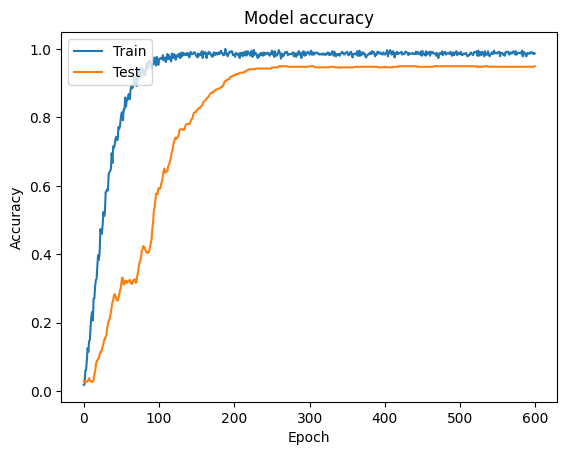

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_110_test1.png")
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
# DD_Net.save_weights('weights/coarse_heavy.h1')

In [17]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [18]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [19]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9495652173913044


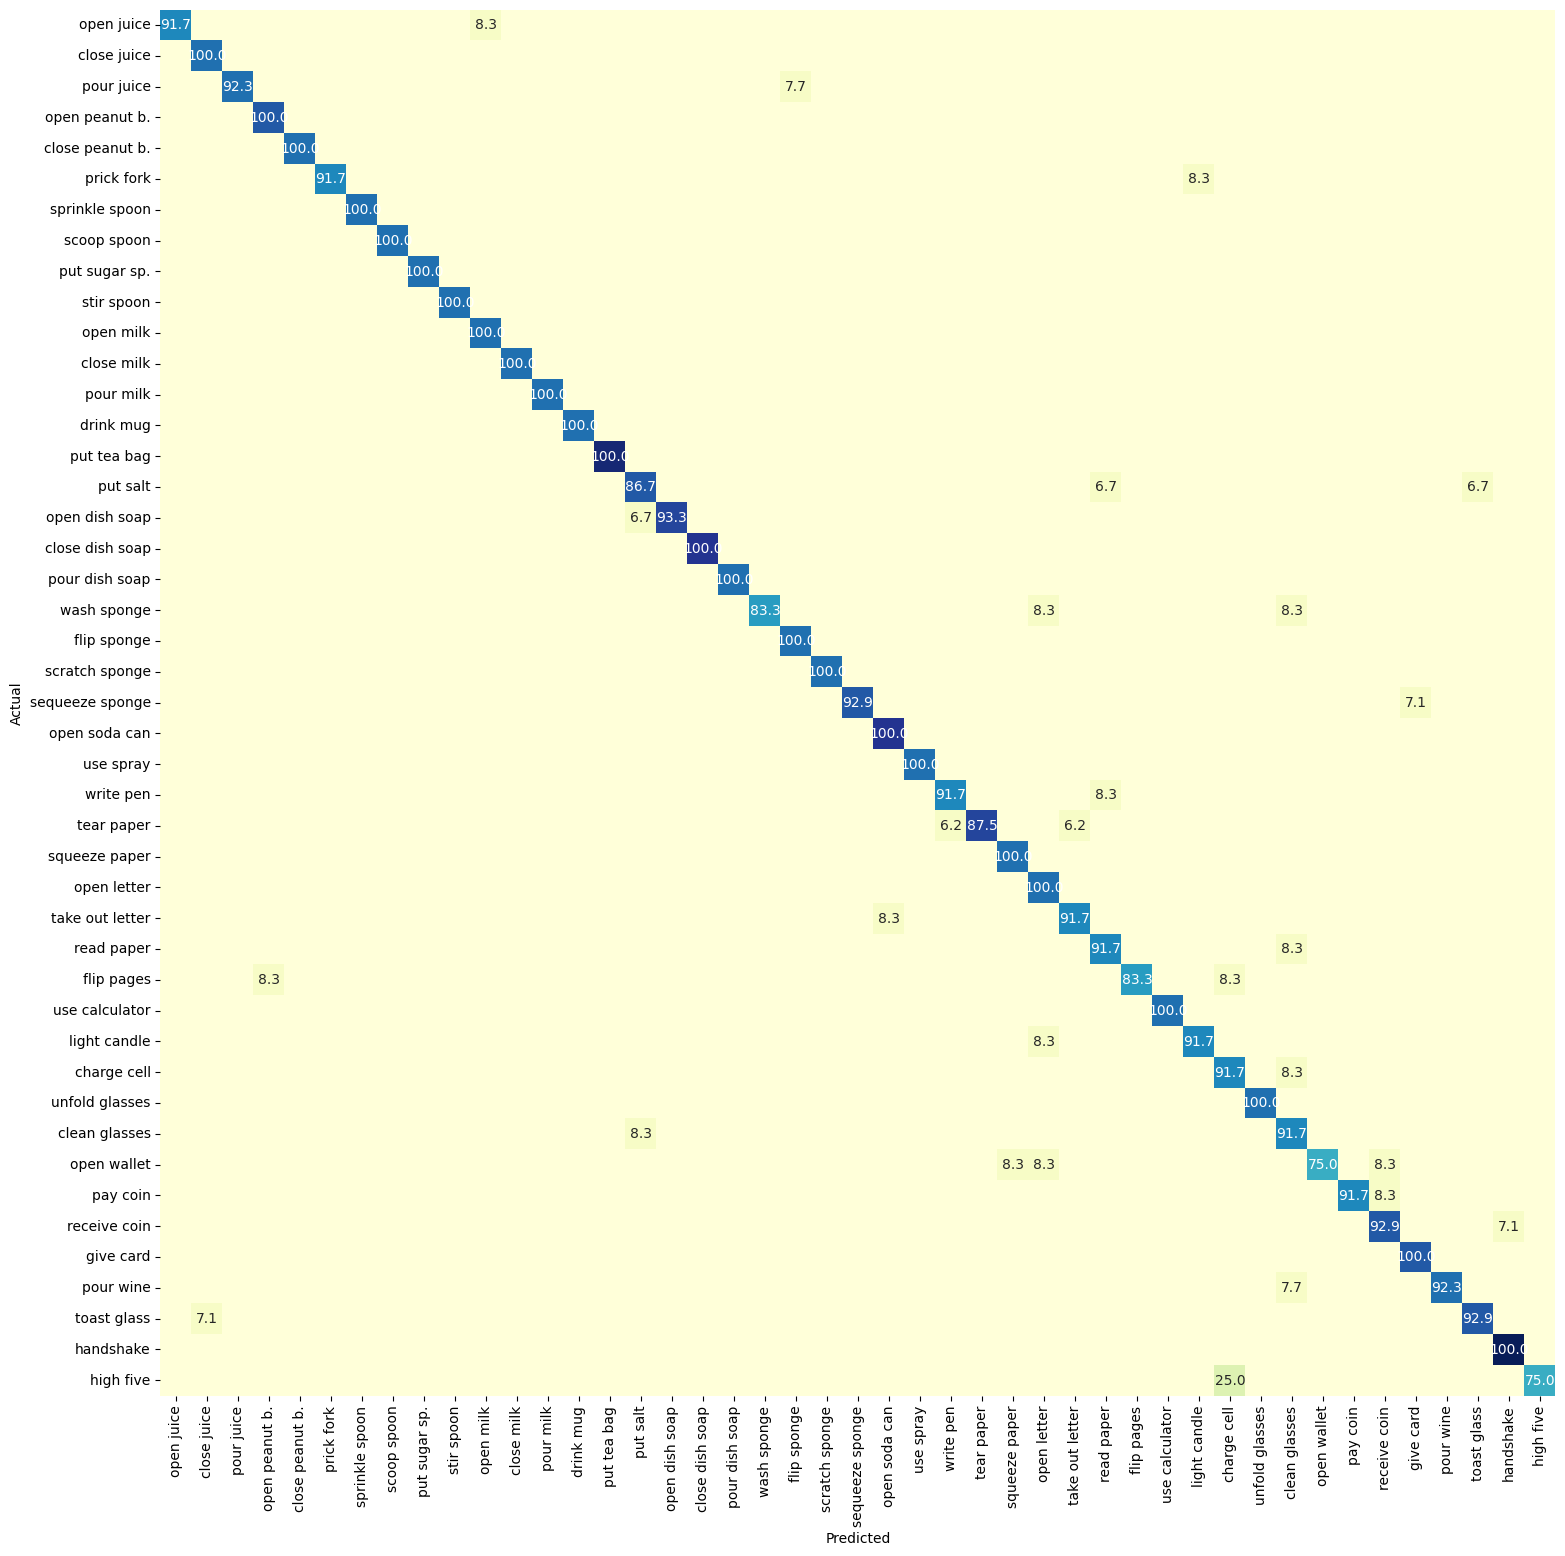

In [20]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_110_test2.png', labels, ymap=None, figsize=(18,18))

## Training with frame_sampling

In [21]:
lr = 1e-5
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])

In [22]:
epochs = 20  #20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,20,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net_model = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

epoch0


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.86it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 4s 6ms/step - loss: 0.1875 - accuracy: 0.9900 - val_loss: 0.2312 - val_accuracy: 0.9478
epoch1


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 128.11it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 155us/step - loss: 0.2003 - accuracy: 0.9933 - val_loss: 0.2314 - val_accuracy: 0.9478
epoch2


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.17it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 146us/step - loss: 0.1861 - accuracy: 0.9883 - val_loss: 0.2314 - val_accuracy: 0.9461
epoch3


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 128.59it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 146us/step - loss: 0.1958 - accuracy: 0.9800 - val_loss: 0.2313 - val_accuracy: 0.9478
epoch4


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 126.39it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 152us/step - loss: 0.1934 - accuracy: 0.9817 - val_loss: 0.2311 - val_accuracy: 0.9478
epoch5


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 126.95it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 184us/step - loss: 0.1827 - accuracy: 0.9917 - val_loss: 0.2309 - val_accuracy: 0.9478
epoch6


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 126.58it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 163us/step - loss: 0.2073 - accuracy: 0.9783 - val_loss: 0.2309 - val_accuracy: 0.9478
epoch7


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 128.90it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 149us/step - loss: 0.1979 - accuracy: 0.9817 - val_loss: 0.2308 - val_accuracy: 0.9478
epoch8


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 128.30it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 156us/step - loss: 0.2048 - accuracy: 0.9883 - val_loss: 0.2308 - val_accuracy: 0.9478
epoch9


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 125.27it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 164us/step - loss: 0.1935 - accuracy: 0.9817 - val_loss: 0.2307 - val_accuracy: 0.9478
epoch10


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 129.72it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 150us/step - loss: 0.2117 - accuracy: 0.9817 - val_loss: 0.2307 - val_accuracy: 0.9478
epoch11


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.56it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 187us/step - loss: 0.1749 - accuracy: 0.9900 - val_loss: 0.2308 - val_accuracy: 0.9478
epoch12


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.66it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 141us/step - loss: 0.1869 - accuracy: 0.9900 - val_loss: 0.2309 - val_accuracy: 0.9478
epoch13


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 124.60it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 156us/step - loss: 0.2002 - accuracy: 0.9850 - val_loss: 0.2310 - val_accuracy: 0.9478
epoch14


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 125.57it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 148us/step - loss: 0.2073 - accuracy: 0.9867 - val_loss: 0.2311 - val_accuracy: 0.9478
epoch15


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 127.84it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 145us/step - loss: 0.1936 - accuracy: 0.9867 - val_loss: 0.2311 - val_accuracy: 0.9478
epoch16


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 126.10it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 154us/step - loss: 0.2028 - accuracy: 0.9883 - val_loss: 0.2311 - val_accuracy: 0.9496
epoch17


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 124.88it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 154us/step - loss: 0.2000 - accuracy: 0.9850 - val_loss: 0.2311 - val_accuracy: 0.9496
epoch18


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 124.40it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 156us/step - loss: 0.1800 - accuracy: 0.9900 - val_loss: 0.2311 - val_accuracy: 0.9496
epoch19


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 125.39it/s]


Train on 600 samples, validate on 575 samples
Epoch 1/1
600/600 [==============================] - 0s 156us/step - loss: 0.1895 - accuracy: 0.9883 - val_loss: 0.2310 - val_accuracy: 0.9496


# Plotting confusion matrix

In [23]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [24]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [25]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9495652173913044


In [ ]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_110_test3.png', labels, ymap=None, figsize=(18,18))

# Policy gradient for frame selection  -------train

In [26]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.nn import Linear,ReLU,CrossEntropyLoss,Sequential,Conv2d,MaxPool2d,Module,Softmax,BatchNorm2d,Dropout
from torch.optim import Adam,SGD

from numpy.random import default_rng
from utils import *

from numpy.random import default_rng


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


gamma = 0.7


class Policy(nn.Module):
    def __init__(self, n_states, n_actions, hidden_size, learning_rate=1e-4):
        super(Policy, self).__init__()

        self.n_actions = n_actions 

        self.cnn_layers = Sequential(Conv2d(1, 32, kernel_size=2),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(32, 64, kernel_size=3, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),
                                     Conv2d(64, 128, kernel_size=2, padding=1),
                                     ReLU(inplace=True),
                                     MaxPool2d(kernel_size=1),) 

        self.linear_layers = Sequential(
            Linear(7680,3)) #32 8448  #7680
#         optimizer = Adam(model.parameters(), lr=0.001)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):  
        x = x.float()
        x = self.cnn_layers(x)
        # x=x.size
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        x = F.softmax(x, dim=1)
        return x 
    
    def select_action(self, state):  
        # state = torch.from_numpy(state).float().unsqueeze(0)
        pr = self.forward(Variable(state))   
        act = np.random.choice(self.n_actions, p=np.squeeze(pr.detach().numpy())) 
        log_pr = torch.log(pr.squeeze(0)[act]) 
        return act, log_pr
  
            
def update_policy(policy_network, rewards, log_probs): 
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        count = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**count * r   
            count +=count
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-4) 
    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()


def calculate_reward(Probs, Probs_history , true_class): 
  ## Probs is the outcome of softmax layer from classifier CNN # Probs : N_classes * 1
  ## Probs_history i the output of previous iteration
  ## true_class is an integer from [1-10]
  ## iteration is the number of iterations passed from the beginning
  omega = 5 # a measure of how strong are the punishments and stimulations
  predicted_class = np.argmax(Probs) + 1
  prev_predicted_class = np.argmax(Probs_history) + 1  ## +1 is bcz classes are from 1 to 10
  
  
  if (predicted_class == true_class and not(prev_predicted_class == true_class) ):
    reward = omega  ## stimulation
  elif ( not(predicted_class == true_class) and (prev_predicted_class == true_class) ):
    reward = - omega ## punishment
  else:
    true_class = int(true_class)
    reward = (np.sign(Probs[true_class - 1]  - Probs_history[true_class - 1])) ## -1 is bcz classes are from 1 to 10

  return reward   
 
def train(oridata,labels): 
    n_states=32 
    n_actions=3 
    # env.seed(random_seed)
    policy_net = Policy(n_states, n_actions, 128) 
    max_episode_num =  1
    max_steps = 32  
    all_rewards = []

    label_new=[]
    final_ind=[]
    for episode in tqdm(range(max_episode_num)):        
        rewards2=[]
        x_tr=[]
        for v in tqdm(range(len(oridata))):
            log_probs = []
            rewards = []
#             x_tr_1=[]
            rng = default_rng()
            Action=[]
            if len(oridata[v])>=32:
#                 rng = default_rng()
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=False))   
            else:
                MM=np.sort(rng.choice(len(oridata[v]),size=32,replace=True))  
            XX=oridata[v] 
            original_fr=XX.clone().detach() 
            original_label=labels[v].numpy()
            
            for steps in range(len(MM)):
                state = original_fr[MM[steps]]
                state = state.reshape(1, 1, 20, 3)
                state = torch.Tensor(state)
                action, log_prob = policy_net.select_action(state)
                Action.append(action)

                if action == 0 :
                    if steps == 0:
                        a = 0
                    else:
                        a = math.ceil(((MM[steps - 1]) + MM[steps]) / 2)
                    d = min(1, MM[steps] - a)
                    MM[steps] = MM[steps] - d
                if action == 1:
                    MM[steps] = MM[steps]
                if action == 2:
                    if steps == len(MM) - 1:
                        a = len(original_fr)
                    else:
                        a = math.ceil((MM[steps] + MM[steps + 1]) / 2)
                    d = min(1, a - MM[steps] - 1)
                    MM[steps] = MM[steps] + d

                xm1 = XX[MM]
                xmm = xm1

                q = np.array(xm1)
                q = zoom(q,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)


                M = get_CG(q,C)  
                q = q.reshape(1,32,20,3)
                M = M.reshape(1,32,190)

                original_fr = XX
                output = DD_Net.predict([M,q])       
                prob = output
                prediction = np.argmax(output,axis=1)

                prob=prob[0]
                if (steps == 0):
                  reward = 1 if prediction==original_label else -1  
                else:
                  reward=calculate_reward(prob, Probs_history ,original_label)
                Probs_history=prob 
                log_probs.append(log_prob)
                rewards.append(reward)
            
                if steps==len(MM) - 1:
                    xm1_step = XX[MM]
            x_tr.append(xm1_step)
            rewards2.append(np.mean(rewards))
            update_policy(policy_net, rewards, log_probs)    
            label_new.append(original_label)

        x_tr = torch.stack(x_tr)
        
        if episode==max_episode_num-1:
          final_ind.append(Action)
            

        
        R=np.sum((rewards2))
        all_rewards.append(R)
 
    return all_rewards,x_tr,policy_net

/home/l/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
Train = pickle.load(open(C.data_dir+"train.pkl","rb"))

oridata = []

for i in tqdm(range(len(Train['pose']))):
    ori = np.copy(Train['pose'][i]).reshape([-1,20,3]) 
    ori = torch.tensor(ori)
    oridata.append(ori)
    
labels = [int(Train['label'][i]) for i in (range(len(Train['pose'])))]
labels = torch.Tensor(labels)
labels_original = labels

100%|██████████████████████████████████████| 600/600 [00:00<00:00, 27078.66it/s]


### epoch 1

In [29]:
all_rewards,x_trnew,policy_net=train(oridata,labels_original)

 16%|██████▋                                   | 95/600 [01:07<05:55,  1.42it/s]


 32%|█████████████                            | 192/600 [02:17<04:53,  1.39it/s]


 48%|███████████████████▋                     | 289/600 [03:28<03:40,  1.41it/s]


 64%|██████████████████████████▍              | 386/600 [04:39<02:37,  1.36it/s]


 80%|█████████████████████████████████        | 483/600 [05:49<01:18,  1.48it/s]


 97%|███████████████████████████████████████▋ | 580/600 [06:59<00:14,  1.36it/s]


100%|████████████████████████████████████████████| 1/1 [07:14<00:00, 434.55s/it]


[-24.40625]


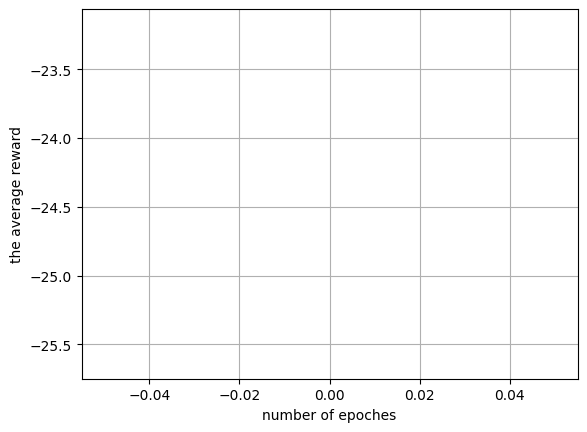

In [30]:
print(all_rewards)
plt.plot(all_rewards)
plt.xlabel('number of epoches')
plt.ylabel('the average reward')
plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_110_test4.png")
plt.grid()

In [31]:
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew))):
    w_p = np.copy(x_trnew[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 600/600 [00:04<00:00, 140.71it/s]


In [32]:
# it may takes several times to reach the reported performance

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  #history使得训练结果可视化
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 4s 7ms/step - loss: 0.3059 - accuracy: 0.9600 - val_loss: 0.3431 - val_accuracy: 0.9235
Epoch 2/600
600/600 [==============================] - 0s 145us/step - loss: 0.3365 - accuracy: 0.9583 - val_loss: 0.4168 - val_accuracy: 0.8991
Epoch 3/600
600/600 [==============================] - 0s 150us/step - loss: 0.3050 - accuracy: 0.9600 - val_loss: 0.4116 - val_accuracy: 0.8957
Epoch 4/600
600/600 [==============================] - 0s 150us/step - loss: 0.3525 - accuracy: 0.9350 - val_loss: 0.4303 - val_accuracy: 0.8783
Epoch 5/600
600/600 [==============================] - 0s 151us/step - loss: 0.3287 - accuracy: 0.9333 - val_loss: 0.6011 - val_accuracy: 0.8400
Epoch 6/600
600/600 [==============================] - 0s 150us/step - loss: 0.3092 - accuracy: 0.9483 - val_loss: 0.5909 - val_accuracy: 0.8487
Epoch 7/600
600/600 [==============================] - 0s 157us/step - loss: 0.2781 - 

Epoch 57/600
600/600 [==============================] - 0s 175us/step - loss: 0.0927 - accuracy: 0.9917 - val_loss: 0.3476 - val_accuracy: 0.8991
Epoch 58/600
600/600 [==============================] - 0s 163us/step - loss: 0.0920 - accuracy: 0.9967 - val_loss: 0.3469 - val_accuracy: 0.8991
Epoch 59/600
600/600 [==============================] - 0s 157us/step - loss: 0.1088 - accuracy: 0.9900 - val_loss: 0.3439 - val_accuracy: 0.9009
Epoch 60/600
600/600 [==============================] - 0s 160us/step - loss: 0.1040 - accuracy: 0.9900 - val_loss: 0.3431 - val_accuracy: 0.9026
Epoch 61/600
600/600 [==============================] - 0s 169us/step - loss: 0.1022 - accuracy: 0.9967 - val_loss: 0.3402 - val_accuracy: 0.9043
Epoch 62/600
600/600 [==============================] - 0s 158us/step - loss: 0.0984 - accuracy: 0.9900 - val_loss: 0.3363 - val_accuracy: 0.9043
Epoch 63/600
600/600 [==============================] - 0s 163us/step - loss: 0.0921 - accuracy: 0.9967 - val_loss: 0.3329 -

600/600 [==============================] - 0s 159us/step - loss: 0.0860 - accuracy: 0.9950 - val_loss: 0.2186 - val_accuracy: 0.9443
Epoch 114/600
600/600 [==============================] - 0s 159us/step - loss: 0.0960 - accuracy: 0.9950 - val_loss: 0.2175 - val_accuracy: 0.9443
Epoch 115/600
600/600 [==============================] - 0s 160us/step - loss: 0.1019 - accuracy: 0.9950 - val_loss: 0.2164 - val_accuracy: 0.9443
Epoch 116/600
600/600 [==============================] - 0s 162us/step - loss: 0.0970 - accuracy: 0.9950 - val_loss: 0.2154 - val_accuracy: 0.9461
Epoch 117/600
600/600 [==============================] - 0s 169us/step - loss: 0.0900 - accuracy: 0.9967 - val_loss: 0.2144 - val_accuracy: 0.9461
Epoch 118/600
600/600 [==============================] - 0s 162us/step - loss: 0.0875 - accuracy: 0.9950 - val_loss: 0.2135 - val_accuracy: 0.9461
Epoch 119/600
600/600 [==============================] - 0s 158us/step - loss: 0.0863 - accuracy: 0.9933 - val_loss: 0.2126 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 160us/step - loss: 0.0921 - accuracy: 0.9917 - val_loss: 0.1899 - val_accuracy: 0.9583
Epoch 170/600
600/600 [==============================] - 0s 156us/step - loss: 0.0805 - accuracy: 0.9967 - val_loss: 0.1897 - val_accuracy: 0.9583
Epoch 171/600
600/600 [==============================] - 0s 159us/step - loss: 0.0878 - accuracy: 0.9917 - val_loss: 0.1895 - val_accuracy: 0.9583
Epoch 172/600
600/600 [==============================] - 0s 159us/step - loss: 0.0982 - accuracy: 0.9950 - val_loss: 0.1894 - val_accuracy: 0.9583
Epoch 173/600
600/600 [==============================] - 0s 156us/step - loss: 0.0846 - accuracy: 0.9917 - val_loss: 0.1892 - val_accuracy: 0.9583
Epoch 174/600
600/600 [==============================] - 0s 166us/step - loss: 0.1021 - accuracy: 0.9950 - val_loss: 0.1891 - val_accuracy: 0.9583
Epoch 175/600
600/600 [==============================] - 0s 154us/step - loss: 0.0898 - accuracy: 0.9900 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 150us/step - loss: 0.1080 - accuracy: 0.9950 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 226/600
600/600 [==============================] - 0s 152us/step - loss: 0.0908 - accuracy: 0.9967 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 227/600
600/600 [==============================] - 0s 159us/step - loss: 0.1001 - accuracy: 0.9883 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 228/600
600/600 [==============================] - 0s 147us/step - loss: 0.1017 - accuracy: 0.9967 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 229/600
600/600 [==============================] - 0s 148us/step - loss: 0.0825 - accuracy: 0.9967 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 230/600
600/600 [==============================] - 0s 143us/step - loss: 0.0937 - accuracy: 0.9950 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 231/600
600/600 [==============================] - 0s 145us/step - loss: 0.0887 - accuracy: 0.9933 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 161us/step - loss: 0.0907 - accuracy: 1.0000 - val_loss: 0.1840 - val_accuracy: 0.9565
Epoch 282/600
600/600 [==============================] - 0s 167us/step - loss: 0.0809 - accuracy: 1.0000 - val_loss: 0.1840 - val_accuracy: 0.9565
Epoch 283/600
600/600 [==============================] - 0s 169us/step - loss: 0.0897 - accuracy: 0.9933 - val_loss: 0.1841 - val_accuracy: 0.9565
Epoch 284/600
600/600 [==============================] - 0s 157us/step - loss: 0.0856 - accuracy: 0.9983 - val_loss: 0.1841 - val_accuracy: 0.9565
Epoch 285/600
600/600 [==============================] - 0s 165us/step - loss: 0.0896 - accuracy: 0.9917 - val_loss: 0.1841 - val_accuracy: 0.9583
Epoch 286/600
600/600 [==============================] - 0s 164us/step - loss: 0.0735 - accuracy: 0.9983 - val_loss: 0.1842 - val_accuracy: 0.9583
Epoch 287/600
600/600 [==============================] - 0s 172us/step - loss: 0.0774 - accuracy: 0.9967 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 163us/step - loss: 0.0786 - accuracy: 0.9983 - val_loss: 0.1842 - val_accuracy: 0.9583
Epoch 338/600
600/600 [==============================] - 0s 172us/step - loss: 0.0847 - accuracy: 0.9917 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 339/600
600/600 [==============================] - 0s 163us/step - loss: 0.0789 - accuracy: 0.9950 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 340/600
600/600 [==============================] - 0s 161us/step - loss: 0.0908 - accuracy: 0.9850 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 341/600
600/600 [==============================] - 0s 161us/step - loss: 0.0852 - accuracy: 0.9933 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 342/600
600/600 [==============================] - 0s 166us/step - loss: 0.1022 - accuracy: 0.9900 - val_loss: 0.1844 - val_accuracy: 0.9583
Epoch 343/600
600/600 [==============================] - 0s 162us/step - loss: 0.0792 - accuracy: 0.9967 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 161us/step - loss: 0.0920 - accuracy: 0.9950 - val_loss: 0.1833 - val_accuracy: 0.9565
Epoch 394/600
600/600 [==============================] - 0s 160us/step - loss: 0.0760 - accuracy: 0.9917 - val_loss: 0.1832 - val_accuracy: 0.9565
Epoch 395/600
600/600 [==============================] - 0s 163us/step - loss: 0.0857 - accuracy: 0.9967 - val_loss: 0.1831 - val_accuracy: 0.9565
Epoch 396/600
600/600 [==============================] - 0s 170us/step - loss: 0.0821 - accuracy: 0.9933 - val_loss: 0.1831 - val_accuracy: 0.9565
Epoch 397/600
600/600 [==============================] - 0s 163us/step - loss: 0.1102 - accuracy: 0.9900 - val_loss: 0.1830 - val_accuracy: 0.9565
Epoch 398/600
600/600 [==============================] - 0s 167us/step - loss: 0.0839 - accuracy: 0.9983 - val_loss: 0.1830 - val_accuracy: 0.9565
Epoch 399/600
600/600 [==============================] - 0s 169us/step - loss: 0.0768 - accuracy: 0.9967 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 156us/step - loss: 0.0839 - accuracy: 0.9950 - val_loss: 0.1824 - val_accuracy: 0.9583
Epoch 450/600
600/600 [==============================] - 0s 156us/step - loss: 0.0859 - accuracy: 0.9933 - val_loss: 0.1824 - val_accuracy: 0.9583
Epoch 451/600
600/600 [==============================] - 0s 153us/step - loss: 0.0744 - accuracy: 0.9983 - val_loss: 0.1824 - val_accuracy: 0.9583
Epoch 452/600
600/600 [==============================] - 0s 161us/step - loss: 0.0794 - accuracy: 0.9983 - val_loss: 0.1824 - val_accuracy: 0.9583
Epoch 453/600
600/600 [==============================] - 0s 156us/step - loss: 0.0833 - accuracy: 0.9967 - val_loss: 0.1825 - val_accuracy: 0.9583
Epoch 454/600
600/600 [==============================] - 0s 157us/step - loss: 0.0896 - accuracy: 0.9950 - val_loss: 0.1825 - val_accuracy: 0.9583
Epoch 455/600
600/600 [==============================] - 0s 161us/step - loss: 0.0940 - accuracy: 1.0000 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 165us/step - loss: 0.0835 - accuracy: 0.9950 - val_loss: 0.1849 - val_accuracy: 0.9565
Epoch 506/600
600/600 [==============================] - 0s 166us/step - loss: 0.0882 - accuracy: 0.9983 - val_loss: 0.1849 - val_accuracy: 0.9565
Epoch 507/600
600/600 [==============================] - 0s 160us/step - loss: 0.0909 - accuracy: 0.9950 - val_loss: 0.1850 - val_accuracy: 0.9565
Epoch 508/600
600/600 [==============================] - 0s 167us/step - loss: 0.0854 - accuracy: 0.9933 - val_loss: 0.1850 - val_accuracy: 0.9565
Epoch 509/600
600/600 [==============================] - 0s 161us/step - loss: 0.0903 - accuracy: 0.9950 - val_loss: 0.1850 - val_accuracy: 0.9565
Epoch 510/600
600/600 [==============================] - 0s 163us/step - loss: 0.0764 - accuracy: 1.0000 - val_loss: 0.1850 - val_accuracy: 0.9565
Epoch 511/600
600/600 [==============================] - 0s 153us/step - loss: 0.0906 - accuracy: 0.9950 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 148us/step - loss: 0.0940 - accuracy: 0.9917 - val_loss: 0.1851 - val_accuracy: 0.9565
Epoch 562/600
600/600 [==============================] - 0s 150us/step - loss: 0.0945 - accuracy: 0.9950 - val_loss: 0.1851 - val_accuracy: 0.9565
Epoch 563/600
600/600 [==============================] - 0s 154us/step - loss: 0.0813 - accuracy: 0.9950 - val_loss: 0.1851 - val_accuracy: 0.9565
Epoch 564/600
600/600 [==============================] - 0s 148us/step - loss: 0.0789 - accuracy: 0.9967 - val_loss: 0.1851 - val_accuracy: 0.9565
Epoch 565/600
600/600 [==============================] - 0s 143us/step - loss: 0.0839 - accuracy: 0.9983 - val_loss: 0.1851 - val_accuracy: 0.9565
Epoch 566/600
600/600 [==============================] - 0s 149us/step - loss: 0.0926 - accuracy: 0.9933 - val_loss: 0.1850 - val_accuracy: 0.9565
Epoch 567/600
600/600 [==============================] - 0s 145us/step - loss: 0.0848 - accuracy: 0.9900 - val_loss: 0

In [33]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [34]:
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [35]:
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9565217391304348


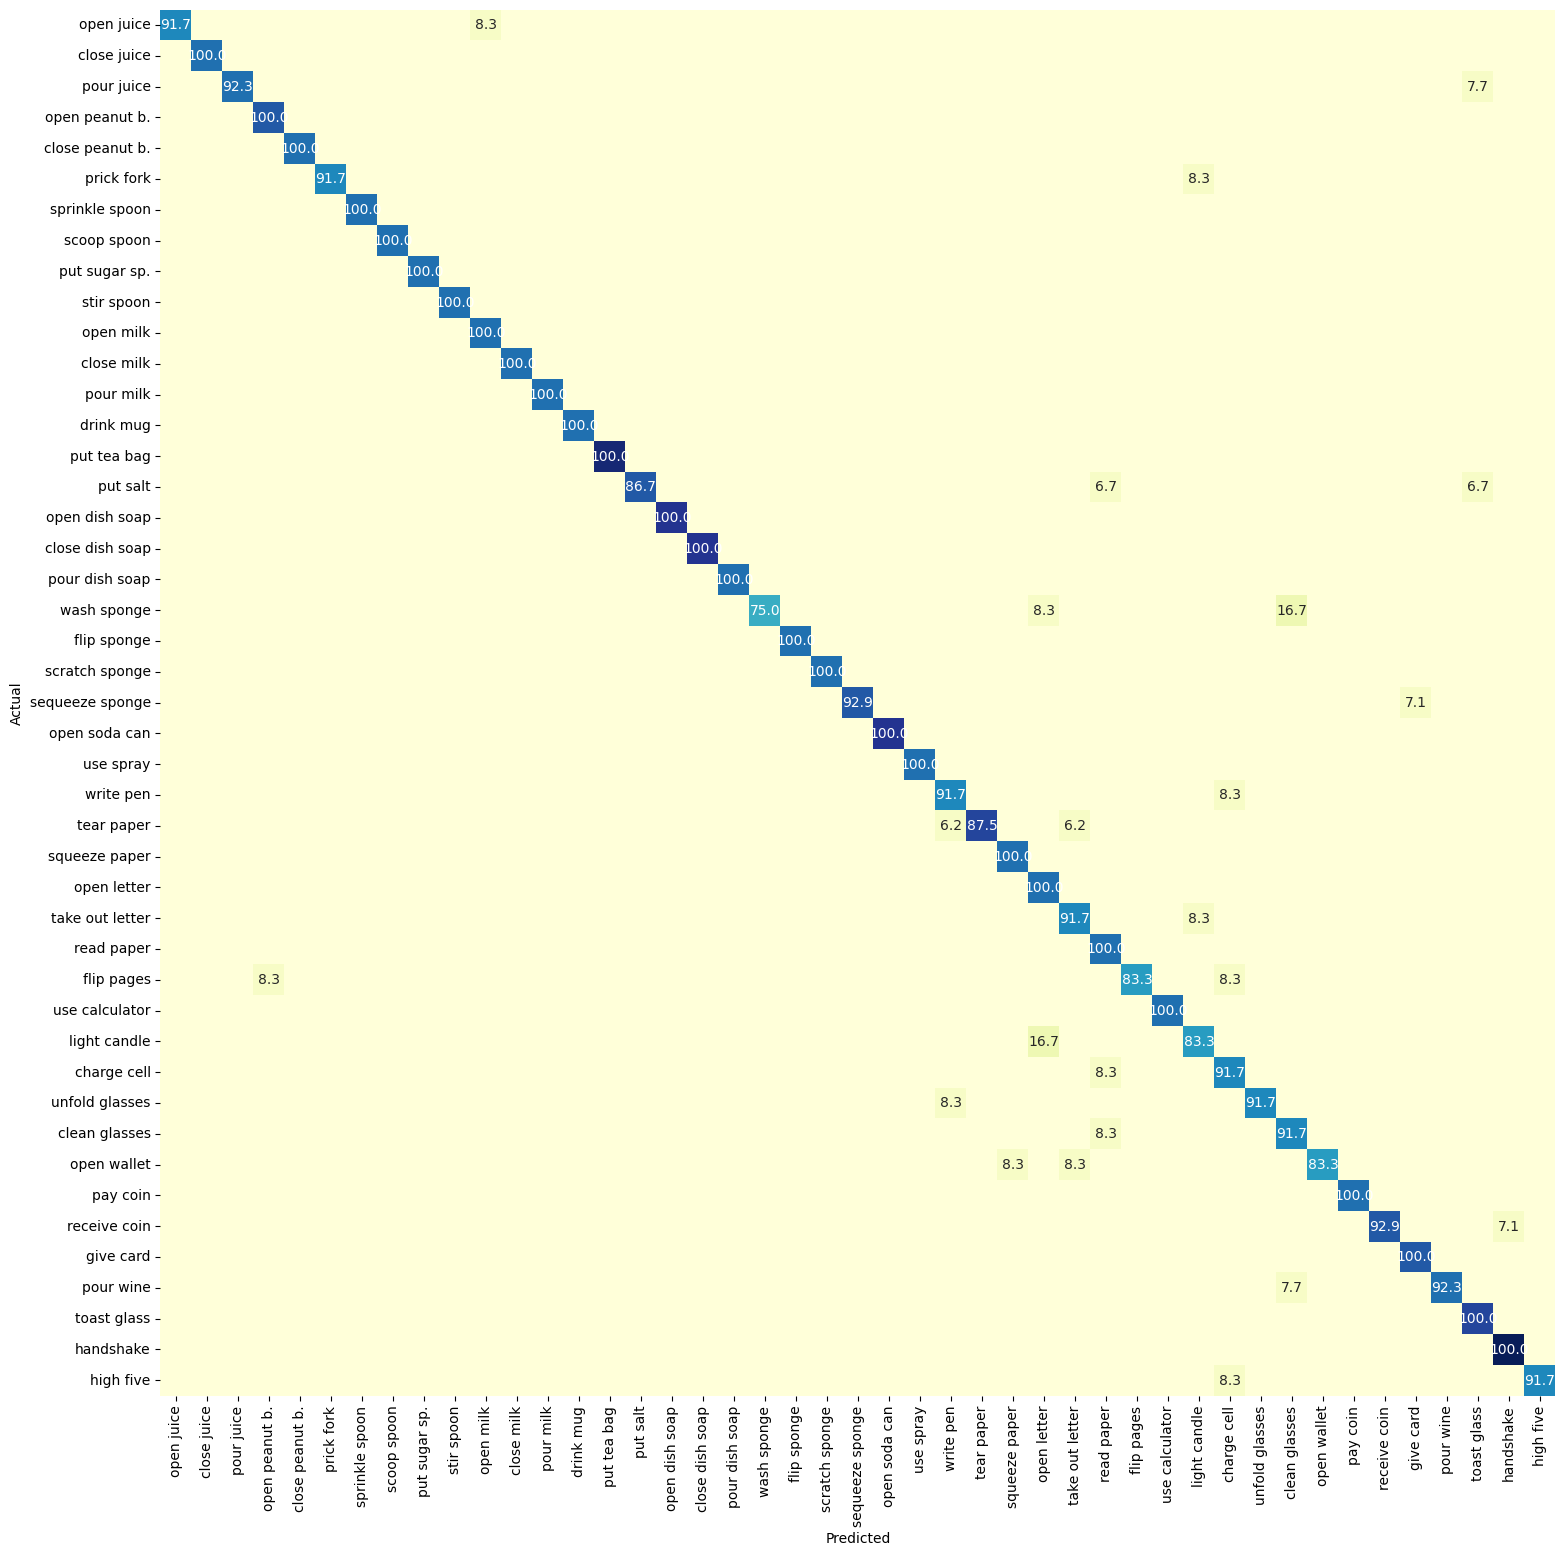

In [36]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_110_test5.png', labels, ymap=None, figsize=(18,18))

### epoch 2 

In [37]:
all_rewards,x_trnew_2,policy_net=train(x_trnew,labels_original)

 16%|██████▋                                   | 95/600 [01:07<06:05,  1.38it/s]


 32%|█████████████                            | 192/600 [02:15<04:36,  1.48it/s]


 48%|███████████████████▋                     | 289/600 [03:26<03:25,  1.51it/s]


 64%|██████████████████████████▍              | 386/600 [04:33<02:16,  1.57it/s]


 80%|█████████████████████████████████        | 483/600 [05:39<01:21,  1.43it/s]


 97%|███████████████████████████████████████▋ | 580/600 [06:47<00:14,  1.40it/s]


100%|████████████████████████████████████████████| 1/1 [07:01<00:00, 421.68s/it]


[-18.75]


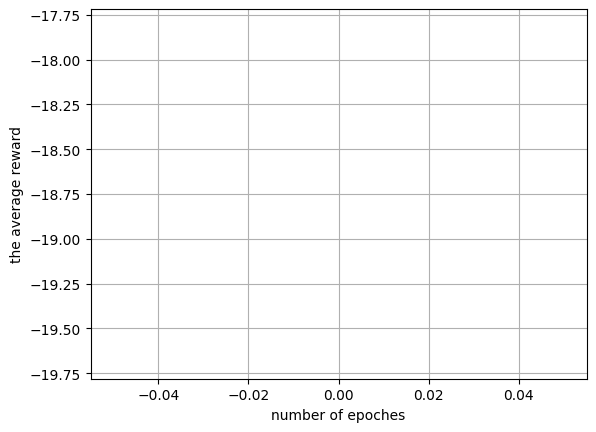

In [38]:
print(all_rewards)
#plt.plot(all_rewards)
#plt.xlabel('number of epoches')
#plt.ylabel('the average reward')
#plt.savefig("/data/HRC/paper1-RLDDNet/code/Main/DD-Net-master/FPHAB/images/DRLDDNet_110_test1.png")
#plt.grid()

In [39]:
X_4 =[]
X_5 = []
labels_rl = []

for i in tqdm(range(len(x_trnew_2))):
    w_p = np.copy(x_trnew_2[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

100%|████████████████████████████████████████| 600/600 [00:04<00:00, 136.33it/s]


In [40]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl, 
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 4s 6ms/step - loss: 0.0789 - accuracy: 0.9967 - val_loss: 0.4053 - val_accuracy: 0.9043
Epoch 2/600
600/600 [==============================] - 0s 144us/step - loss: 0.0954 - accuracy: 0.9900 - val_loss: 0.4091 - val_accuracy: 0.8904
Epoch 3/600
600/600 [==============================] - 0s 144us/step - loss: 0.0945 - accuracy: 0.9933 - val_loss: 0.4203 - val_accuracy: 0.8870
Epoch 4/600
600/600 [==============================] - 0s 139us/step - loss: 0.1084 - accuracy: 0.9867 - val_loss: 0.6283 - val_accuracy: 0.8157
Epoch 5/600
600/600 [==============================] - 0s 141us/step - loss: 0.1218 - accuracy: 0.9883 - val_loss: 0.7928 - val_accuracy: 0.7878
Epoch 6/600
600/600 [==============================] - 0s 156us/step - loss: 0.1146 - accuracy: 0.9817 - val_loss: 0.6306 - val_accuracy: 0.8174
Epoch 7/600
600/600 [==============================] - 0s 143us/step - loss: 0.1213 - 

Epoch 57/600
600/600 [==============================] - 0s 151us/step - loss: 0.0633 - accuracy: 0.9950 - val_loss: 0.2236 - val_accuracy: 0.9513
Epoch 58/600
600/600 [==============================] - 0s 152us/step - loss: 0.0708 - accuracy: 0.9967 - val_loss: 0.2232 - val_accuracy: 0.9513
Epoch 59/600
600/600 [==============================] - 0s 149us/step - loss: 0.0593 - accuracy: 0.9983 - val_loss: 0.2227 - val_accuracy: 0.9530
Epoch 60/600
600/600 [==============================] - 0s 165us/step - loss: 0.0583 - accuracy: 0.9983 - val_loss: 0.2222 - val_accuracy: 0.9530
Epoch 61/600
600/600 [==============================] - 0s 154us/step - loss: 0.0626 - accuracy: 0.9983 - val_loss: 0.2221 - val_accuracy: 0.9530
Epoch 62/600
600/600 [==============================] - 0s 154us/step - loss: 0.0665 - accuracy: 0.9933 - val_loss: 0.2219 - val_accuracy: 0.9513
Epoch 63/600
600/600 [==============================] - 0s 158us/step - loss: 0.0680 - accuracy: 0.9967 - val_loss: 0.2216 -

600/600 [==============================] - 0s 155us/step - loss: 0.0569 - accuracy: 0.9967 - val_loss: 0.2045 - val_accuracy: 0.9565
Epoch 114/600
600/600 [==============================] - 0s 156us/step - loss: 0.0648 - accuracy: 0.9967 - val_loss: 0.2042 - val_accuracy: 0.9565
Epoch 115/600
600/600 [==============================] - 0s 154us/step - loss: 0.0567 - accuracy: 0.9983 - val_loss: 0.2040 - val_accuracy: 0.9565
Epoch 116/600
600/600 [==============================] - 0s 153us/step - loss: 0.0652 - accuracy: 0.9967 - val_loss: 0.2037 - val_accuracy: 0.9565
Epoch 117/600
600/600 [==============================] - 0s 156us/step - loss: 0.0609 - accuracy: 0.9983 - val_loss: 0.2035 - val_accuracy: 0.9565
Epoch 118/600
600/600 [==============================] - 0s 154us/step - loss: 0.0630 - accuracy: 0.9950 - val_loss: 0.2033 - val_accuracy: 0.9565
Epoch 119/600
600/600 [==============================] - 0s 151us/step - loss: 0.0632 - accuracy: 0.9967 - val_loss: 0.2031 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 148us/step - loss: 0.0620 - accuracy: 0.9967 - val_loss: 0.1953 - val_accuracy: 0.9548
Epoch 170/600
600/600 [==============================] - 0s 138us/step - loss: 0.0615 - accuracy: 0.9933 - val_loss: 0.1951 - val_accuracy: 0.9548
Epoch 171/600
600/600 [==============================] - 0s 143us/step - loss: 0.0644 - accuracy: 0.9967 - val_loss: 0.1949 - val_accuracy: 0.9548
Epoch 172/600
600/600 [==============================] - 0s 150us/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.1948 - val_accuracy: 0.9548
Epoch 173/600
600/600 [==============================] - 0s 134us/step - loss: 0.0689 - accuracy: 0.9967 - val_loss: 0.1947 - val_accuracy: 0.9548
Epoch 174/600
600/600 [==============================] - 0s 129us/step - loss: 0.0639 - accuracy: 0.9950 - val_loss: 0.1945 - val_accuracy: 0.9548
Epoch 175/600
600/600 [==============================] - 0s 133us/step - loss: 0.0673 - accuracy: 0.9950 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 139us/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.1909 - val_accuracy: 0.9548
Epoch 226/600
600/600 [==============================] - 0s 154us/step - loss: 0.0642 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9548
Epoch 227/600
600/600 [==============================] - 0s 138us/step - loss: 0.0612 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9565
Epoch 228/600
600/600 [==============================] - 0s 129us/step - loss: 0.0580 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9565
Epoch 229/600
600/600 [==============================] - 0s 136us/step - loss: 0.0530 - accuracy: 0.9967 - val_loss: 0.1908 - val_accuracy: 0.9565
Epoch 230/600
600/600 [==============================] - 0s 131us/step - loss: 0.0678 - accuracy: 0.9967 - val_loss: 0.1908 - val_accuracy: 0.9565
Epoch 231/600
600/600 [==============================] - 0s 133us/step - loss: 0.0648 - accuracy: 0.9983 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 153us/step - loss: 0.0668 - accuracy: 0.9950 - val_loss: 0.1883 - val_accuracy: 0.9565
Epoch 282/600
600/600 [==============================] - 0s 150us/step - loss: 0.0644 - accuracy: 0.9933 - val_loss: 0.1883 - val_accuracy: 0.9565
Epoch 283/600
600/600 [==============================] - 0s 157us/step - loss: 0.0656 - accuracy: 0.9967 - val_loss: 0.1882 - val_accuracy: 0.9565
Epoch 284/600
600/600 [==============================] - 0s 156us/step - loss: 0.0613 - accuracy: 0.9983 - val_loss: 0.1881 - val_accuracy: 0.9565
Epoch 285/600
600/600 [==============================] - 0s 161us/step - loss: 0.0639 - accuracy: 0.9950 - val_loss: 0.1881 - val_accuracy: 0.9565
Epoch 286/600
600/600 [==============================] - 0s 155us/step - loss: 0.0504 - accuracy: 0.9983 - val_loss: 0.1880 - val_accuracy: 0.9565
Epoch 287/600
600/600 [==============================] - 0s 167us/step - loss: 0.0554 - accuracy: 0.9983 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 151us/step - loss: 0.0489 - accuracy: 0.9983 - val_loss: 0.1870 - val_accuracy: 0.9600
Epoch 338/600
600/600 [==============================] - 0s 153us/step - loss: 0.0686 - accuracy: 0.9917 - val_loss: 0.1869 - val_accuracy: 0.9600
Epoch 339/600
600/600 [==============================] - 0s 156us/step - loss: 0.0577 - accuracy: 0.9950 - val_loss: 0.1868 - val_accuracy: 0.9600
Epoch 340/600
600/600 [==============================] - 0s 151us/step - loss: 0.0545 - accuracy: 0.9983 - val_loss: 0.1867 - val_accuracy: 0.9600
Epoch 341/600
600/600 [==============================] - 0s 160us/step - loss: 0.0664 - accuracy: 0.9967 - val_loss: 0.1866 - val_accuracy: 0.9600
Epoch 342/600
600/600 [==============================] - 0s 150us/step - loss: 0.0611 - accuracy: 0.9983 - val_loss: 0.1865 - val_accuracy: 0.9600
Epoch 343/600
600/600 [==============================] - 0s 156us/step - loss: 0.0568 - accuracy: 0.9950 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 153us/step - loss: 0.0633 - accuracy: 0.9983 - val_loss: 0.1830 - val_accuracy: 0.9617
Epoch 394/600
600/600 [==============================] - 0s 150us/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.1831 - val_accuracy: 0.9617
Epoch 395/600
600/600 [==============================] - 0s 155us/step - loss: 0.0527 - accuracy: 0.9950 - val_loss: 0.1831 - val_accuracy: 0.9617
Epoch 396/600
600/600 [==============================] - 0s 153us/step - loss: 0.0612 - accuracy: 0.9933 - val_loss: 0.1831 - val_accuracy: 0.9617
Epoch 397/600
600/600 [==============================] - 0s 152us/step - loss: 0.0571 - accuracy: 0.9983 - val_loss: 0.1832 - val_accuracy: 0.9617
Epoch 398/600
600/600 [==============================] - 0s 155us/step - loss: 0.0574 - accuracy: 0.9967 - val_loss: 0.1832 - val_accuracy: 0.9617
Epoch 399/600
600/600 [==============================] - 0s 153us/step - loss: 0.0515 - accuracy: 0.9983 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 155us/step - loss: 0.0566 - accuracy: 0.9983 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 450/600
600/600 [==============================] - 0s 152us/step - loss: 0.0554 - accuracy: 0.9967 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 451/600
600/600 [==============================] - 0s 154us/step - loss: 0.0635 - accuracy: 0.9950 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 452/600
600/600 [==============================] - 0s 165us/step - loss: 0.0499 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 453/600
600/600 [==============================] - 0s 165us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 0.1824 - val_accuracy: 0.9600
Epoch 454/600
600/600 [==============================] - 0s 157us/step - loss: 0.0646 - accuracy: 0.9983 - val_loss: 0.1825 - val_accuracy: 0.9600
Epoch 455/600
600/600 [==============================] - 0s 155us/step - loss: 0.0668 - accuracy: 0.9950 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 134us/step - loss: 0.0594 - accuracy: 0.9983 - val_loss: 0.1828 - val_accuracy: 0.9600
Epoch 506/600
600/600 [==============================] - 0s 137us/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.1829 - val_accuracy: 0.9600
Epoch 507/600
600/600 [==============================] - 0s 142us/step - loss: 0.0568 - accuracy: 0.9967 - val_loss: 0.1830 - val_accuracy: 0.9600
Epoch 508/600
600/600 [==============================] - 0s 137us/step - loss: 0.0665 - accuracy: 0.9933 - val_loss: 0.1831 - val_accuracy: 0.9600
Epoch 509/600
600/600 [==============================] - 0s 135us/step - loss: 0.0645 - accuracy: 0.9933 - val_loss: 0.1831 - val_accuracy: 0.9600
Epoch 510/600
600/600 [==============================] - 0s 138us/step - loss: 0.0537 - accuracy: 0.9933 - val_loss: 0.1831 - val_accuracy: 0.9600
Epoch 511/600
600/600 [==============================] - 0s 136us/step - loss: 0.0491 - accuracy: 0.9983 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 131us/step - loss: 0.0528 - accuracy: 0.9967 - val_loss: 0.1823 - val_accuracy: 0.9600
Epoch 562/600
600/600 [==============================] - 0s 140us/step - loss: 0.0711 - accuracy: 0.9917 - val_loss: 0.1823 - val_accuracy: 0.9600
Epoch 563/600
600/600 [==============================] - 0s 136us/step - loss: 0.0496 - accuracy: 0.9983 - val_loss: 0.1822 - val_accuracy: 0.9600
Epoch 564/600
600/600 [==============================] - 0s 134us/step - loss: 0.0508 - accuracy: 0.9967 - val_loss: 0.1821 - val_accuracy: 0.9600
Epoch 565/600
600/600 [==============================] - 0s 144us/step - loss: 0.0543 - accuracy: 0.9967 - val_loss: 0.1821 - val_accuracy: 0.9600
Epoch 566/600
600/600 [==============================] - 0s 140us/step - loss: 0.0599 - accuracy: 0.9933 - val_loss: 0.1820 - val_accuracy: 0.9600
Epoch 567/600
600/600 [==============================] - 0s 136us/step - loss: 0.0583 - accuracy: 0.9933 - val_loss: 0

In [41]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9634782608695652


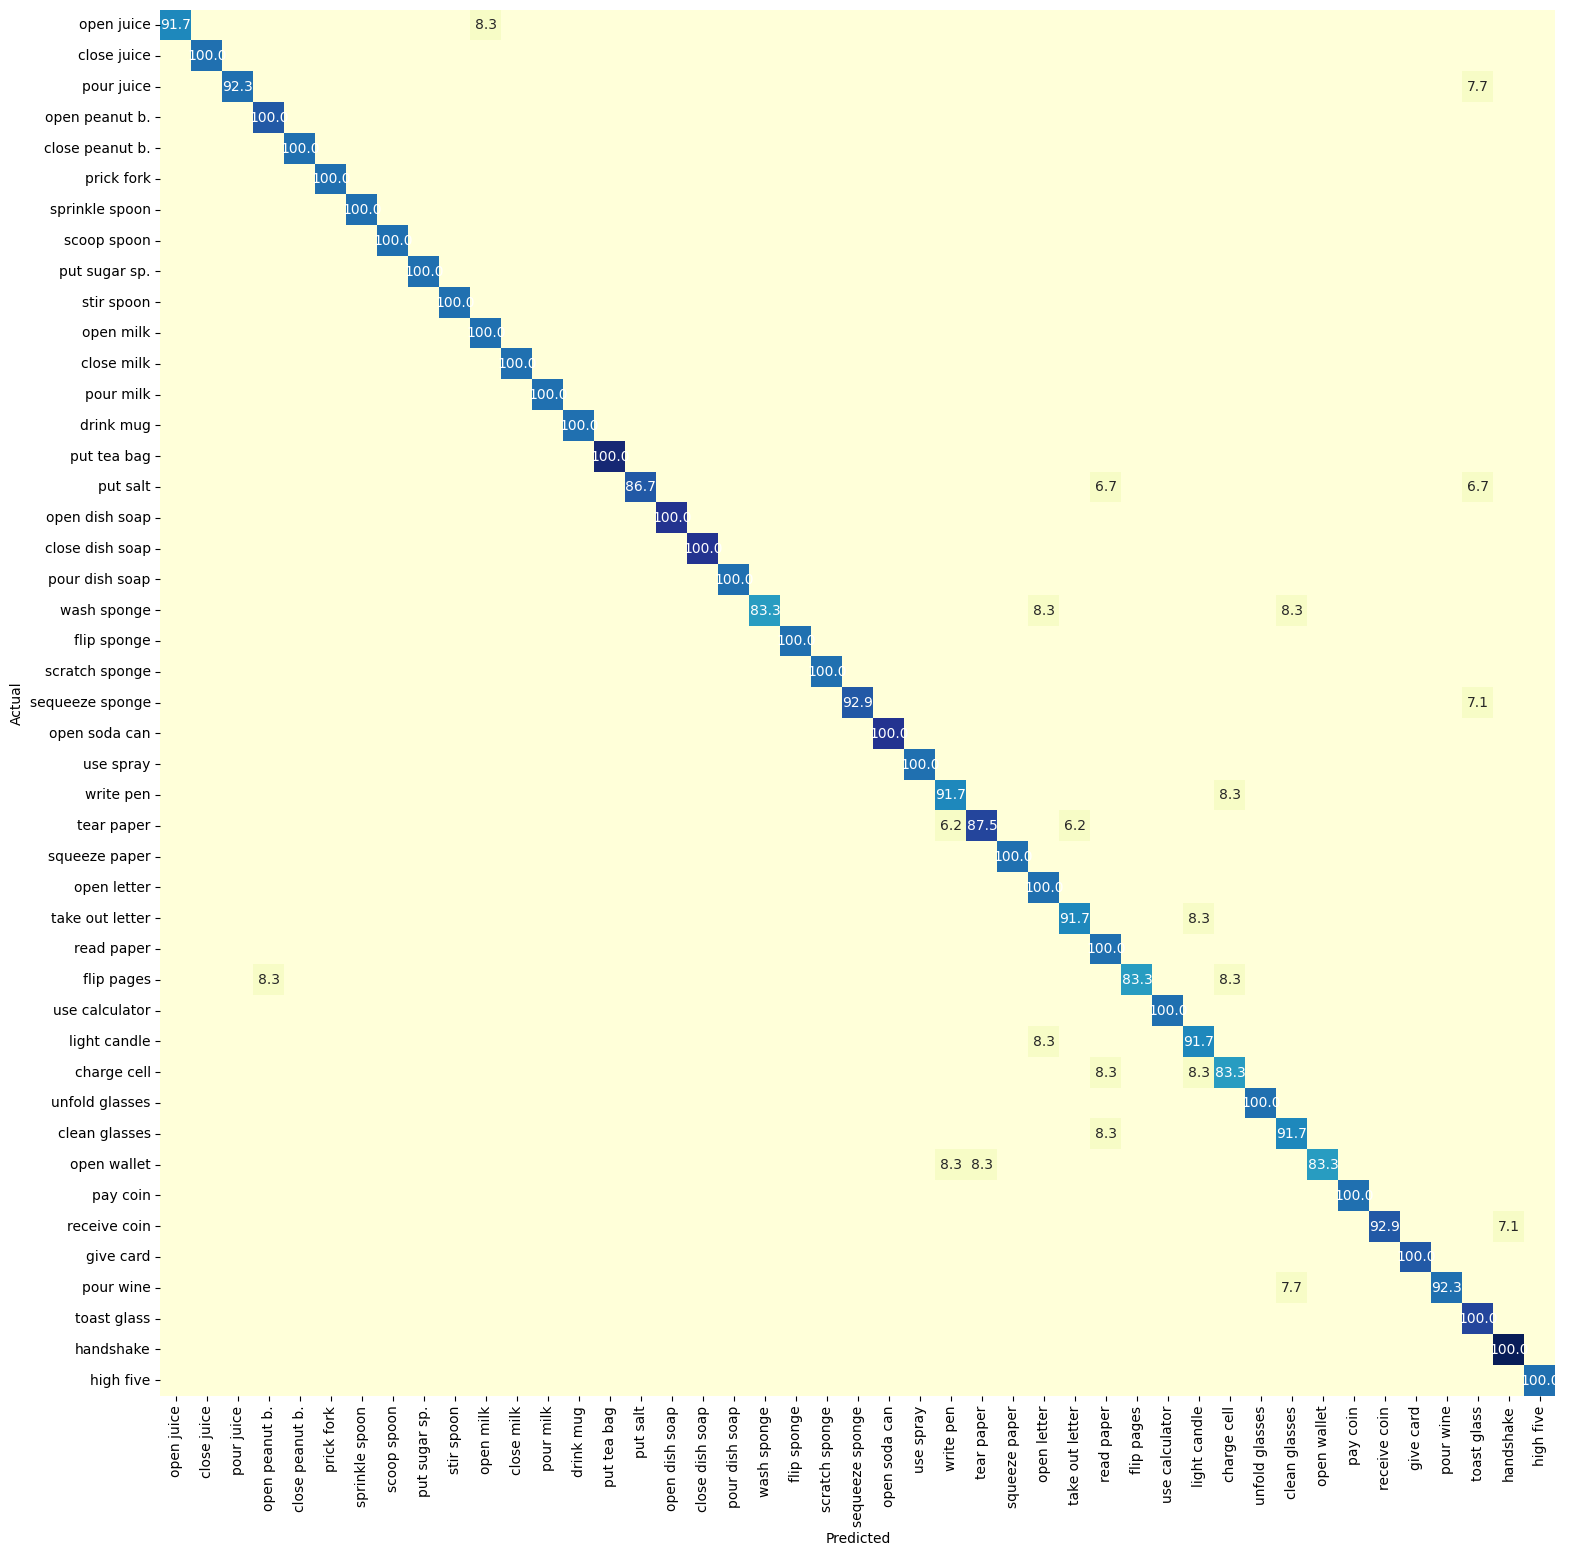

In [42]:
cm_analysis(y_true,y_pred, 'images/DRLDDNet_110_test6.png', labels, ymap=None, figsize=(18,18))

### epoch 3 

In [43]:
all_rewards,x_trnew_3,policy_net=train(x_trnew_2,labels_original)
print(all_rewards)
X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_3))):
    w_p = np.copy(x_trnew_3[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 16%|██████▋                                   | 95/600 [01:10<06:28,  1.30it/s]


 32%|█████████████                            | 192/600 [02:22<05:07,  1.33it/s]


 48%|███████████████████▋                     | 289/600 [03:34<03:50,  1.35it/s]


 64%|██████████████████████████▍              | 386/600 [04:45<02:36,  1.36it/s]


 80%|█████████████████████████████████        | 483/600 [05:57<01:29,  1.31it/s]


 97%|███████████████████████████████████████▋ | 580/600 [07:08<00:13,  1.44it/s]


100%|████████████████████████████████████████████| 1/1 [07:23<00:00, 443.43s/it]


[-18.75]


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 135.15it/s]


In [44]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 4s 6ms/step - loss: 0.0443 - accuracy: 0.9983 - val_loss: 0.5721 - val_accuracy: 0.8696
Epoch 2/600
600/600 [==============================] - 0s 148us/step - loss: 0.0948 - accuracy: 0.9883 - val_loss: 0.3449 - val_accuracy: 0.9061
Epoch 3/600
600/600 [==============================] - 0s 139us/step - loss: 0.0905 - accuracy: 0.9900 - val_loss: 0.4400 - val_accuracy: 0.8817
Epoch 4/600
600/600 [==============================] - 0s 137us/step - loss: 0.0813 - accuracy: 0.9883 - val_loss: 0.4774 - val_accuracy: 0.8730
Epoch 5/600
600/600 [==============================] - 0s 136us/step - loss: 0.1044 - accuracy: 0.9817 - val_loss: 0.4456 - val_accuracy: 0.8870
Epoch 6/600
600/600 [==============================] - 0s 146us/step - loss: 0.0734 - accuracy: 0.9950 - val_loss: 0.4756 - val_accuracy: 0.8765
Epoch 7/600
600/600 [==============================] - 0s 146us/step - loss: 0.0989 - 

Epoch 57/600
600/600 [==============================] - 0s 152us/step - loss: 0.0464 - accuracy: 0.9983 - val_loss: 0.3066 - val_accuracy: 0.9096
Epoch 58/600
600/600 [==============================] - 0s 155us/step - loss: 0.0548 - accuracy: 0.9967 - val_loss: 0.3024 - val_accuracy: 0.9096
Epoch 59/600
600/600 [==============================] - 0s 170us/step - loss: 0.0528 - accuracy: 0.9983 - val_loss: 0.2988 - val_accuracy: 0.9113
Epoch 60/600
600/600 [==============================] - 0s 161us/step - loss: 0.0448 - accuracy: 0.9983 - val_loss: 0.2953 - val_accuracy: 0.9130
Epoch 61/600
600/600 [==============================] - 0s 150us/step - loss: 0.0484 - accuracy: 0.9967 - val_loss: 0.2923 - val_accuracy: 0.9148
Epoch 62/600
600/600 [==============================] - 0s 153us/step - loss: 0.0501 - accuracy: 0.9933 - val_loss: 0.2893 - val_accuracy: 0.9148
Epoch 63/600
600/600 [==============================] - 0s 154us/step - loss: 0.0444 - accuracy: 0.9967 - val_loss: 0.2865 -

600/600 [==============================] - 0s 143us/step - loss: 0.0474 - accuracy: 0.9983 - val_loss: 0.2175 - val_accuracy: 0.9478
Epoch 114/600
600/600 [==============================] - 0s 151us/step - loss: 0.0482 - accuracy: 0.9950 - val_loss: 0.2168 - val_accuracy: 0.9478
Epoch 115/600
600/600 [==============================] - 0s 147us/step - loss: 0.0483 - accuracy: 1.0000 - val_loss: 0.2161 - val_accuracy: 0.9478
Epoch 116/600
600/600 [==============================] - 0s 155us/step - loss: 0.0598 - accuracy: 0.9967 - val_loss: 0.2154 - val_accuracy: 0.9478
Epoch 117/600
600/600 [==============================] - 0s 147us/step - loss: 0.0552 - accuracy: 0.9983 - val_loss: 0.2147 - val_accuracy: 0.9496
Epoch 118/600
600/600 [==============================] - 0s 151us/step - loss: 0.0511 - accuracy: 0.9933 - val_loss: 0.2140 - val_accuracy: 0.9496
Epoch 119/600
600/600 [==============================] - 0s 145us/step - loss: 0.0484 - accuracy: 0.9933 - val_loss: 0.2133 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 146us/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.9583
Epoch 170/600
600/600 [==============================] - 0s 166us/step - loss: 0.0487 - accuracy: 1.0000 - val_loss: 0.1942 - val_accuracy: 0.9583
Epoch 171/600
600/600 [==============================] - 0s 146us/step - loss: 0.0491 - accuracy: 0.9950 - val_loss: 0.1940 - val_accuracy: 0.9583
Epoch 172/600
600/600 [==============================] - 0s 149us/step - loss: 0.0454 - accuracy: 0.9950 - val_loss: 0.1939 - val_accuracy: 0.9583
Epoch 173/600
600/600 [==============================] - 0s 151us/step - loss: 0.0471 - accuracy: 0.9967 - val_loss: 0.1937 - val_accuracy: 0.9583
Epoch 174/600
600/600 [==============================] - 0s 153us/step - loss: 0.0517 - accuracy: 0.9967 - val_loss: 0.1936 - val_accuracy: 0.9583
Epoch 175/600
600/600 [==============================] - 0s 163us/step - loss: 0.0502 - accuracy: 0.9933 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 149us/step - loss: 0.0517 - accuracy: 0.9950 - val_loss: 0.1888 - val_accuracy: 0.9565
Epoch 226/600
600/600 [==============================] - 0s 151us/step - loss: 0.0541 - accuracy: 0.9950 - val_loss: 0.1887 - val_accuracy: 0.9565
Epoch 227/600
600/600 [==============================] - 0s 151us/step - loss: 0.0425 - accuracy: 0.9983 - val_loss: 0.1886 - val_accuracy: 0.9565
Epoch 228/600
600/600 [==============================] - 0s 151us/step - loss: 0.0497 - accuracy: 0.9967 - val_loss: 0.1885 - val_accuracy: 0.9565
Epoch 229/600
600/600 [==============================] - 0s 150us/step - loss: 0.0495 - accuracy: 0.9967 - val_loss: 0.1884 - val_accuracy: 0.9565
Epoch 230/600
600/600 [==============================] - 0s 150us/step - loss: 0.0376 - accuracy: 0.9983 - val_loss: 0.1884 - val_accuracy: 0.9565
Epoch 231/600
600/600 [==============================] - 0s 149us/step - loss: 0.0429 - accuracy: 1.0000 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 140us/step - loss: 0.0467 - accuracy: 0.9983 - val_loss: 0.1876 - val_accuracy: 0.9565
Epoch 282/600
600/600 [==============================] - 0s 144us/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.1875 - val_accuracy: 0.9565
Epoch 283/600
600/600 [==============================] - 0s 139us/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0.1875 - val_accuracy: 0.9565
Epoch 284/600
600/600 [==============================] - 0s 145us/step - loss: 0.0462 - accuracy: 0.9967 - val_loss: 0.1875 - val_accuracy: 0.9565
Epoch 285/600
600/600 [==============================] - 0s 139us/step - loss: 0.0485 - accuracy: 0.9967 - val_loss: 0.1874 - val_accuracy: 0.9565
Epoch 286/600
600/600 [==============================] - 0s 138us/step - loss: 0.0412 - accuracy: 0.9983 - val_loss: 0.1874 - val_accuracy: 0.9565
Epoch 287/600
600/600 [==============================] - 0s 135us/step - loss: 0.0454 - accuracy: 0.9950 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 137us/step - loss: 0.0446 - accuracy: 0.9967 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 338/600
600/600 [==============================] - 0s 151us/step - loss: 0.0424 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 339/600
600/600 [==============================] - 0s 140us/step - loss: 0.0417 - accuracy: 0.9967 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 340/600
600/600 [==============================] - 0s 140us/step - loss: 0.0374 - accuracy: 1.0000 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 341/600
600/600 [==============================] - 0s 138us/step - loss: 0.0458 - accuracy: 0.9983 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 342/600
600/600 [==============================] - 0s 139us/step - loss: 0.0518 - accuracy: 0.9950 - val_loss: 0.1855 - val_accuracy: 0.9583
Epoch 343/600
600/600 [==============================] - 0s 140us/step - loss: 0.0367 - accuracy: 0.9983 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 148us/step - loss: 0.0453 - accuracy: 0.9967 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 394/600
600/600 [==============================] - 0s 149us/step - loss: 0.0490 - accuracy: 0.9983 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 395/600
600/600 [==============================] - 0s 157us/step - loss: 0.0426 - accuracy: 0.9967 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 396/600
600/600 [==============================] - 0s 156us/step - loss: 0.0464 - accuracy: 0.9983 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 397/600
600/600 [==============================] - 0s 147us/step - loss: 0.0494 - accuracy: 0.9950 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 398/600
600/600 [==============================] - 0s 154us/step - loss: 0.0414 - accuracy: 0.9967 - val_loss: 0.1852 - val_accuracy: 0.9583
Epoch 399/600
600/600 [==============================] - 0s 150us/step - loss: 0.0426 - accuracy: 0.9967 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 142us/step - loss: 0.0555 - accuracy: 0.9933 - val_loss: 0.1850 - val_accuracy: 0.9583
Epoch 450/600
600/600 [==============================] - 0s 138us/step - loss: 0.0408 - accuracy: 0.9983 - val_loss: 0.1849 - val_accuracy: 0.9583
Epoch 451/600
600/600 [==============================] - 0s 144us/step - loss: 0.0430 - accuracy: 0.9967 - val_loss: 0.1848 - val_accuracy: 0.9583
Epoch 452/600
600/600 [==============================] - 0s 143us/step - loss: 0.0468 - accuracy: 0.9950 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 453/600
600/600 [==============================] - 0s 142us/step - loss: 0.0432 - accuracy: 0.9950 - val_loss: 0.1845 - val_accuracy: 0.9583
Epoch 454/600
600/600 [==============================] - 0s 149us/step - loss: 0.0496 - accuracy: 0.9950 - val_loss: 0.1844 - val_accuracy: 0.9583
Epoch 455/600
600/600 [==============================] - 0s 147us/step - loss: 0.0411 - accuracy: 0.9983 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 155us/step - loss: 0.0445 - accuracy: 0.9967 - val_loss: 0.1844 - val_accuracy: 0.9565
Epoch 506/600
600/600 [==============================] - 0s 155us/step - loss: 0.0452 - accuracy: 0.9967 - val_loss: 0.1844 - val_accuracy: 0.9565
Epoch 507/600
600/600 [==============================] - 0s 150us/step - loss: 0.0408 - accuracy: 0.9983 - val_loss: 0.1844 - val_accuracy: 0.9565
Epoch 508/600
600/600 [==============================] - 0s 153us/step - loss: 0.0500 - accuracy: 0.9983 - val_loss: 0.1844 - val_accuracy: 0.9565
Epoch 509/600
600/600 [==============================] - 0s 150us/step - loss: 0.0446 - accuracy: 0.9950 - val_loss: 0.1843 - val_accuracy: 0.9565
Epoch 510/600
600/600 [==============================] - 0s 157us/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 0.1843 - val_accuracy: 0.9565
Epoch 511/600
600/600 [==============================] - 0s 153us/step - loss: 0.0423 - accuracy: 0.9983 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 153us/step - loss: 0.0463 - accuracy: 0.9950 - val_loss: 0.1849 - val_accuracy: 0.9583
Epoch 562/600
600/600 [==============================] - 0s 151us/step - loss: 0.0494 - accuracy: 0.9950 - val_loss: 0.1849 - val_accuracy: 0.9583
Epoch 563/600
600/600 [==============================] - 0s 152us/step - loss: 0.0417 - accuracy: 0.9967 - val_loss: 0.1848 - val_accuracy: 0.9583
Epoch 564/600
600/600 [==============================] - 0s 155us/step - loss: 0.0358 - accuracy: 0.9950 - val_loss: 0.1848 - val_accuracy: 0.9583
Epoch 565/600
600/600 [==============================] - 0s 159us/step - loss: 0.0447 - accuracy: 0.9983 - val_loss: 0.1848 - val_accuracy: 0.9583
Epoch 566/600
600/600 [==============================] - 0s 157us/step - loss: 0.0386 - accuracy: 0.9983 - val_loss: 0.1847 - val_accuracy: 0.9583
Epoch 567/600
600/600 [==============================] - 0s 147us/step - loss: 0.0305 - accuracy: 1.0000 - val_loss: 0

In [45]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9582608695652174


### epoch 4

In [46]:
all_rewards,x_trnew_4,policy_net=train(x_trnew_3,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_4))):
    w_p = np.copy(x_trnew_4[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 16%|██████▋                                   | 95/600 [01:08<05:47,  1.45it/s]


 32%|█████████████                            | 192/600 [02:18<04:49,  1.41it/s]


 48%|███████████████████▋                     | 289/600 [03:28<03:45,  1.38it/s]


 64%|██████████████████████████▍              | 386/600 [04:39<02:31,  1.42it/s]


 80%|█████████████████████████████████        | 483/600 [05:48<01:20,  1.46it/s]


 97%|███████████████████████████████████████▋ | 580/600 [06:57<00:14,  1.41it/s]


100%|████████████████████████████████████████████| 1/1 [07:11<00:00, 431.97s/it]


[-18.75]


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 141.05it/s]


In [47]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 4s 6ms/step - loss: 0.0391 - accuracy: 0.9983 - val_loss: 0.2646 - val_accuracy: 0.9270
Epoch 2/600
600/600 [==============================] - 0s 146us/step - loss: 0.0454 - accuracy: 0.9967 - val_loss: 0.3623 - val_accuracy: 0.9096
Epoch 3/600
600/600 [==============================] - 0s 140us/step - loss: 0.0538 - accuracy: 0.9983 - val_loss: 0.4454 - val_accuracy: 0.8835
Epoch 4/600
600/600 [==============================] - 0s 137us/step - loss: 0.0647 - accuracy: 0.9950 - val_loss: 0.7416 - val_accuracy: 0.7965
Epoch 5/600
600/600 [==============================] - 0s 138us/step - loss: 0.0634 - accuracy: 0.9967 - val_loss: 1.1015 - val_accuracy: 0.7443
Epoch 6/600
600/600 [==============================] - 0s 131us/step - loss: 0.0602 - accuracy: 0.9983 - val_loss: 1.1371 - val_accuracy: 0.7235
Epoch 7/600
600/600 [==============================] - 0s 136us/step - loss: 0.0641 - 

Epoch 57/600
600/600 [==============================] - 0s 151us/step - loss: 0.0401 - accuracy: 0.9967 - val_loss: 0.2240 - val_accuracy: 0.9513
Epoch 58/600
600/600 [==============================] - 0s 145us/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.2236 - val_accuracy: 0.9513
Epoch 59/600
600/600 [==============================] - 0s 147us/step - loss: 0.0409 - accuracy: 0.9983 - val_loss: 0.2233 - val_accuracy: 0.9513
Epoch 60/600
600/600 [==============================] - 0s 147us/step - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.2231 - val_accuracy: 0.9513
Epoch 61/600
600/600 [==============================] - 0s 146us/step - loss: 0.0364 - accuracy: 0.9983 - val_loss: 0.2229 - val_accuracy: 0.9513
Epoch 62/600
600/600 [==============================] - 0s 145us/step - loss: 0.0377 - accuracy: 0.9967 - val_loss: 0.2226 - val_accuracy: 0.9513
Epoch 63/600
600/600 [==============================] - 0s 146us/step - loss: 0.0413 - accuracy: 0.9967 - val_loss: 0.2223 -

600/600 [==============================] - 0s 143us/step - loss: 0.0378 - accuracy: 0.9983 - val_loss: 0.2074 - val_accuracy: 0.9530
Epoch 114/600
600/600 [==============================] - 0s 138us/step - loss: 0.0372 - accuracy: 0.9967 - val_loss: 0.2071 - val_accuracy: 0.9530
Epoch 115/600
600/600 [==============================] - 0s 150us/step - loss: 0.0377 - accuracy: 0.9983 - val_loss: 0.2069 - val_accuracy: 0.9513
Epoch 116/600
600/600 [==============================] - 0s 143us/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.2066 - val_accuracy: 0.9513
Epoch 117/600
600/600 [==============================] - 0s 148us/step - loss: 0.0326 - accuracy: 1.0000 - val_loss: 0.2063 - val_accuracy: 0.9513
Epoch 118/600
600/600 [==============================] - 0s 154us/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.2060 - val_accuracy: 0.9530
Epoch 119/600
600/600 [==============================] - 0s 149us/step - loss: 0.0467 - accuracy: 0.9950 - val_loss: 0.2057 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 150us/step - loss: 0.0412 - accuracy: 0.9983 - val_loss: 0.1973 - val_accuracy: 0.9583
Epoch 170/600
600/600 [==============================] - 0s 136us/step - loss: 0.0330 - accuracy: 0.9950 - val_loss: 0.1972 - val_accuracy: 0.9565
Epoch 171/600
600/600 [==============================] - 0s 148us/step - loss: 0.0379 - accuracy: 0.9967 - val_loss: 0.1970 - val_accuracy: 0.9565
Epoch 172/600
600/600 [==============================] - 0s 141us/step - loss: 0.0353 - accuracy: 0.9983 - val_loss: 0.1968 - val_accuracy: 0.9565
Epoch 173/600
600/600 [==============================] - 0s 151us/step - loss: 0.0358 - accuracy: 0.9950 - val_loss: 0.1966 - val_accuracy: 0.9565
Epoch 174/600
600/600 [==============================] - 0s 163us/step - loss: 0.0378 - accuracy: 0.9983 - val_loss: 0.1965 - val_accuracy: 0.9565
Epoch 175/600
600/600 [==============================] - 0s 153us/step - loss: 0.0386 - accuracy: 0.9967 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 139us/step - loss: 0.0373 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9583
Epoch 226/600
600/600 [==============================] - 0s 132us/step - loss: 0.0330 - accuracy: 0.9983 - val_loss: 0.1910 - val_accuracy: 0.9583
Epoch 227/600
600/600 [==============================] - 0s 139us/step - loss: 0.0433 - accuracy: 0.9950 - val_loss: 0.1910 - val_accuracy: 0.9583
Epoch 228/600
600/600 [==============================] - 0s 136us/step - loss: 0.0359 - accuracy: 0.9983 - val_loss: 0.1910 - val_accuracy: 0.9583
Epoch 229/600
600/600 [==============================] - 0s 146us/step - loss: 0.0329 - accuracy: 0.9983 - val_loss: 0.1910 - val_accuracy: 0.9583
Epoch 230/600
600/600 [==============================] - 0s 136us/step - loss: 0.0293 - accuracy: 0.9967 - val_loss: 0.1909 - val_accuracy: 0.9583
Epoch 231/600
600/600 [==============================] - 0s 145us/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 163us/step - loss: 0.0387 - accuracy: 0.9983 - val_loss: 0.1866 - val_accuracy: 0.9583
Epoch 282/600
600/600 [==============================] - 0s 148us/step - loss: 0.0391 - accuracy: 0.9967 - val_loss: 0.1865 - val_accuracy: 0.9583
Epoch 283/600
600/600 [==============================] - 0s 159us/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.1865 - val_accuracy: 0.9583
Epoch 284/600
600/600 [==============================] - 0s 144us/step - loss: 0.0355 - accuracy: 0.9967 - val_loss: 0.1866 - val_accuracy: 0.9583
Epoch 285/600
600/600 [==============================] - 0s 150us/step - loss: 0.0460 - accuracy: 0.9967 - val_loss: 0.1865 - val_accuracy: 0.9583
Epoch 286/600
600/600 [==============================] - 0s 150us/step - loss: 0.0318 - accuracy: 0.9950 - val_loss: 0.1865 - val_accuracy: 0.9583
Epoch 287/600
600/600 [==============================] - 0s 150us/step - loss: 0.0389 - accuracy: 0.9950 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 154us/step - loss: 0.0360 - accuracy: 0.9967 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 338/600
600/600 [==============================] - 0s 152us/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 339/600
600/600 [==============================] - 0s 155us/step - loss: 0.0295 - accuracy: 0.9983 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 340/600
600/600 [==============================] - 0s 148us/step - loss: 0.0341 - accuracy: 0.9983 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 341/600
600/600 [==============================] - 0s 155us/step - loss: 0.0321 - accuracy: 0.9983 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 342/600
600/600 [==============================] - 0s 147us/step - loss: 0.0312 - accuracy: 1.0000 - val_loss: 0.1849 - val_accuracy: 0.9600
Epoch 343/600
600/600 [==============================] - 0s 153us/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 154us/step - loss: 0.0294 - accuracy: 0.9983 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 394/600
600/600 [==============================] - 0s 151us/step - loss: 0.0339 - accuracy: 0.9983 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 395/600
600/600 [==============================] - 0s 154us/step - loss: 0.0307 - accuracy: 0.9967 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 396/600
600/600 [==============================] - 0s 150us/step - loss: 0.0357 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 397/600
600/600 [==============================] - 0s 154us/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 398/600
600/600 [==============================] - 0s 152us/step - loss: 0.0385 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9583
Epoch 399/600
600/600 [==============================] - 0s 158us/step - loss: 0.0402 - accuracy: 0.9950 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 165us/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9583
Epoch 450/600
600/600 [==============================] - 0s 150us/step - loss: 0.0356 - accuracy: 0.9950 - val_loss: 0.1847 - val_accuracy: 0.9583
Epoch 451/600
600/600 [==============================] - 0s 156us/step - loss: 0.0359 - accuracy: 0.9967 - val_loss: 0.1847 - val_accuracy: 0.9583
Epoch 452/600
600/600 [==============================] - 0s 157us/step - loss: 0.0335 - accuracy: 0.9983 - val_loss: 0.1847 - val_accuracy: 0.9583
Epoch 453/600
600/600 [==============================] - 0s 159us/step - loss: 0.0347 - accuracy: 0.9967 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 454/600
600/600 [==============================] - 0s 159us/step - loss: 0.0314 - accuracy: 0.9983 - val_loss: 0.1846 - val_accuracy: 0.9583
Epoch 455/600
600/600 [==============================] - 0s 160us/step - loss: 0.0437 - accuracy: 0.9950 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 156us/step - loss: 0.0283 - accuracy: 0.9967 - val_loss: 0.1829 - val_accuracy: 0.9583
Epoch 506/600
600/600 [==============================] - 0s 159us/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.1829 - val_accuracy: 0.9583
Epoch 507/600
600/600 [==============================] - 0s 158us/step - loss: 0.0344 - accuracy: 0.9983 - val_loss: 0.1829 - val_accuracy: 0.9583
Epoch 508/600
600/600 [==============================] - 0s 150us/step - loss: 0.0354 - accuracy: 0.9950 - val_loss: 0.1830 - val_accuracy: 0.9583
Epoch 509/600
600/600 [==============================] - 0s 153us/step - loss: 0.0310 - accuracy: 0.9983 - val_loss: 0.1831 - val_accuracy: 0.9583
Epoch 510/600
600/600 [==============================] - 0s 155us/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9583
Epoch 511/600
600/600 [==============================] - 0s 157us/step - loss: 0.0314 - accuracy: 0.9983 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 138us/step - loss: 0.0361 - accuracy: 0.9967 - val_loss: 0.1813 - val_accuracy: 0.9583
Epoch 562/600
600/600 [==============================] - 0s 141us/step - loss: 0.0309 - accuracy: 0.9983 - val_loss: 0.1814 - val_accuracy: 0.9583
Epoch 563/600
600/600 [==============================] - 0s 143us/step - loss: 0.0378 - accuracy: 0.9967 - val_loss: 0.1814 - val_accuracy: 0.9583
Epoch 564/600
600/600 [==============================] - 0s 136us/step - loss: 0.0370 - accuracy: 0.9983 - val_loss: 0.1814 - val_accuracy: 0.9583
Epoch 565/600
600/600 [==============================] - 0s 140us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1814 - val_accuracy: 0.9583
Epoch 566/600
600/600 [==============================] - 0s 135us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.1814 - val_accuracy: 0.9583
Epoch 567/600
600/600 [==============================] - 0s 140us/step - loss: 0.0256 - accuracy: 1.0000 - val_loss: 0

In [48]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9582608695652174


### epoch 5

In [49]:
all_rewards,x_trnew_5,policy_net=train(x_trnew_4,labels_original)
print(all_rewards)

X_4 =[]
X_5 = []
labels_rl = []


for i in tqdm(range(len(x_trnew_5))):
    w_p = np.copy(x_trnew_5[i]).reshape([-1,20,3]) 
    w_p = np.array(w_p)
    w_p = zoom(w_p,target_l = C.frame_l,joints_num = C.joint_n, joints_dim = C.joint_d)
    w_p = normlize_range(w_p)

    w_M = get_CG(w_p,C)

    label_rl = np.zeros(C.clc_coarse)
    label_rl[int(labels_original[i]) - 1] = 1 

    X_4.append(w_M)
    X_5.append(w_p)
    labels_rl.append(label_rl)

X_4 = np.stack(X_4)
X_5 = np.stack(X_5)
labels_rl = np.stack(labels_rl)

 16%|██████▋                                   | 95/600 [01:04<05:38,  1.49it/s]


 32%|█████████████                            | 192/600 [02:14<04:53,  1.39it/s]


 48%|███████████████████▋                     | 289/600 [03:23<03:48,  1.36it/s]


 64%|██████████████████████████▍              | 386/600 [04:33<02:31,  1.41it/s]


 80%|█████████████████████████████████        | 483/600 [05:44<01:27,  1.34it/s]


 97%|███████████████████████████████████████▋ | 580/600 [06:53<00:14,  1.39it/s]


100%|████████████████████████████████████████████| 1/1 [07:08<00:00, 428.12s/it]


[-18.75]


100%|████████████████████████████████████████| 600/600 [00:04<00:00, 138.21it/s]


In [50]:
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_4,X_5],labels_rl,  
            batch_size=len(labels_rl),
            epochs=600, #400
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 600 samples, validate on 575 samples
Epoch 1/600
600/600 [==============================] - 4s 6ms/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.5395 - val_accuracy: 0.8922
Epoch 2/600
600/600 [==============================] - 0s 162us/step - loss: 0.0850 - accuracy: 0.9883 - val_loss: 0.2953 - val_accuracy: 0.9217
Epoch 3/600
600/600 [==============================] - 0s 149us/step - loss: 0.0545 - accuracy: 0.9900 - val_loss: 0.3240 - val_accuracy: 0.9217
Epoch 4/600
600/600 [==============================] - 0s 137us/step - loss: 0.0940 - accuracy: 0.9850 - val_loss: 0.4596 - val_accuracy: 0.8957
Epoch 5/600
600/600 [==============================] - 0s 143us/step - loss: 0.0709 - accuracy: 0.9900 - val_loss: 0.7421 - val_accuracy: 0.8226
Epoch 6/600
600/600 [==============================] - 0s 136us/step - loss: 0.0732 - accuracy: 0.9833 - val_loss: 0.8193 - val_accuracy: 0.7896
Epoch 7/600
600/600 [==============================] - 0s 143us/step - loss: 0.0566 - 

Epoch 57/600
600/600 [==============================] - 0s 144us/step - loss: 0.0319 - accuracy: 0.9967 - val_loss: 0.2042 - val_accuracy: 0.9530
Epoch 58/600
600/600 [==============================] - 0s 143us/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.2038 - val_accuracy: 0.9548
Epoch 59/600
600/600 [==============================] - 0s 144us/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.2033 - val_accuracy: 0.9548
Epoch 60/600
600/600 [==============================] - 0s 145us/step - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.2029 - val_accuracy: 0.9548
Epoch 61/600
600/600 [==============================] - 0s 144us/step - loss: 0.0336 - accuracy: 0.9950 - val_loss: 0.2024 - val_accuracy: 0.9548
Epoch 62/600
600/600 [==============================] - 0s 156us/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.2020 - val_accuracy: 0.9548
Epoch 63/600
600/600 [==============================] - 0s 147us/step - loss: 0.0403 - accuracy: 0.9933 - val_loss: 0.2017 -

600/600 [==============================] - 0s 161us/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 0.1911 - val_accuracy: 0.9530
Epoch 114/600
600/600 [==============================] - 0s 147us/step - loss: 0.0339 - accuracy: 0.9967 - val_loss: 0.1910 - val_accuracy: 0.9530
Epoch 115/600
600/600 [==============================] - 0s 150us/step - loss: 0.0286 - accuracy: 0.9983 - val_loss: 0.1909 - val_accuracy: 0.9530
Epoch 116/600
600/600 [==============================] - 0s 160us/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.1908 - val_accuracy: 0.9530
Epoch 117/600
600/600 [==============================] - 0s 155us/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.1907 - val_accuracy: 0.9530
Epoch 118/600
600/600 [==============================] - 0s 147us/step - loss: 0.0415 - accuracy: 0.9983 - val_loss: 0.1906 - val_accuracy: 0.9530
Epoch 119/600
600/600 [==============================] - 0s 153us/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 0.1905 - val_ac

Epoch 169/600
600/600 [==============================] - 0s 137us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.1914 - val_accuracy: 0.9565
Epoch 170/600
600/600 [==============================] - 0s 132us/step - loss: 0.0301 - accuracy: 0.9983 - val_loss: 0.1915 - val_accuracy: 0.9565
Epoch 171/600
600/600 [==============================] - 0s 144us/step - loss: 0.0273 - accuracy: 0.9967 - val_loss: 0.1914 - val_accuracy: 0.9565
Epoch 172/600
600/600 [==============================] - 0s 127us/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 0.1914 - val_accuracy: 0.9565
Epoch 173/600
600/600 [==============================] - 0s 139us/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.1914 - val_accuracy: 0.9565
Epoch 174/600
600/600 [==============================] - 0s 131us/step - loss: 0.0390 - accuracy: 0.9950 - val_loss: 0.1914 - val_accuracy: 0.9565
Epoch 175/600
600/600 [==============================] - 0s 137us/step - loss: 0.0372 - accuracy: 0.9967 - val_loss: 0

Epoch 225/600
600/600 [==============================] - 0s 136us/step - loss: 0.0365 - accuracy: 0.9950 - val_loss: 0.1924 - val_accuracy: 0.9548
Epoch 226/600
600/600 [==============================] - 0s 134us/step - loss: 0.0324 - accuracy: 0.9933 - val_loss: 0.1926 - val_accuracy: 0.9548
Epoch 227/600
600/600 [==============================] - 0s 154us/step - loss: 0.0388 - accuracy: 0.9950 - val_loss: 0.1927 - val_accuracy: 0.9548
Epoch 228/600
600/600 [==============================] - 0s 141us/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9548
Epoch 229/600
600/600 [==============================] - 0s 145us/step - loss: 0.0332 - accuracy: 0.9933 - val_loss: 0.1929 - val_accuracy: 0.9548
Epoch 230/600
600/600 [==============================] - 0s 139us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1929 - val_accuracy: 0.9548
Epoch 231/600
600/600 [==============================] - 0s 147us/step - loss: 0.0270 - accuracy: 0.9967 - val_loss: 0

Epoch 281/600
600/600 [==============================] - 0s 143us/step - loss: 0.0262 - accuracy: 0.9983 - val_loss: 0.1938 - val_accuracy: 0.9548
Epoch 282/600
600/600 [==============================] - 0s 153us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1938 - val_accuracy: 0.9565
Epoch 283/600
600/600 [==============================] - 0s 142us/step - loss: 0.0273 - accuracy: 0.9983 - val_loss: 0.1939 - val_accuracy: 0.9565
Epoch 284/600
600/600 [==============================] - 0s 138us/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.1939 - val_accuracy: 0.9565
Epoch 285/600
600/600 [==============================] - 0s 138us/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 0.1939 - val_accuracy: 0.9565
Epoch 286/600
600/600 [==============================] - 0s 145us/step - loss: 0.0263 - accuracy: 0.9983 - val_loss: 0.1939 - val_accuracy: 0.9565
Epoch 287/600
600/600 [==============================] - 0s 154us/step - loss: 0.0343 - accuracy: 0.9983 - val_loss: 0

Epoch 337/600
600/600 [==============================] - 0s 146us/step - loss: 0.0248 - accuracy: 0.9983 - val_loss: 0.1944 - val_accuracy: 0.9548
Epoch 338/600
600/600 [==============================] - 0s 138us/step - loss: 0.0306 - accuracy: 0.9967 - val_loss: 0.1944 - val_accuracy: 0.9548
Epoch 339/600
600/600 [==============================] - 0s 149us/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.9548
Epoch 340/600
600/600 [==============================] - 0s 137us/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9548
Epoch 341/600
600/600 [==============================] - 0s 150us/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.1945 - val_accuracy: 0.9548
Epoch 342/600
600/600 [==============================] - 0s 144us/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.1946 - val_accuracy: 0.9548
Epoch 343/600
600/600 [==============================] - 0s 155us/step - loss: 0.0325 - accuracy: 0.9950 - val_loss: 0

Epoch 393/600
600/600 [==============================] - 0s 149us/step - loss: 0.0288 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 0.9565
Epoch 394/600
600/600 [==============================] - 0s 160us/step - loss: 0.0303 - accuracy: 0.9983 - val_loss: 0.1964 - val_accuracy: 0.9565
Epoch 395/600
600/600 [==============================] - 0s 153us/step - loss: 0.0245 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 0.9565
Epoch 396/600
600/600 [==============================] - 0s 144us/step - loss: 0.0282 - accuracy: 0.9967 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 397/600
600/600 [==============================] - 0s 164us/step - loss: 0.0267 - accuracy: 0.9983 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 398/600
600/600 [==============================] - 0s 151us/step - loss: 0.0320 - accuracy: 0.9950 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 399/600
600/600 [==============================] - 0s 154us/step - loss: 0.0271 - accuracy: 0.9983 - val_loss: 0

Epoch 449/600
600/600 [==============================] - 0s 154us/step - loss: 0.0296 - accuracy: 0.9983 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 450/600
600/600 [==============================] - 0s 134us/step - loss: 0.0330 - accuracy: 0.9983 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 451/600
600/600 [==============================] - 0s 142us/step - loss: 0.0280 - accuracy: 0.9983 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 452/600
600/600 [==============================] - 0s 141us/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 453/600
600/600 [==============================] - 0s 147us/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 454/600
600/600 [==============================] - 0s 143us/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.1963 - val_accuracy: 0.9565
Epoch 455/600
600/600 [==============================] - 0s 148us/step - loss: 0.0313 - accuracy: 0.9983 - val_loss: 0

Epoch 505/600
600/600 [==============================] - 0s 152us/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9583
Epoch 506/600
600/600 [==============================] - 0s 140us/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9583
Epoch 507/600
600/600 [==============================] - 0s 137us/step - loss: 0.0268 - accuracy: 1.0000 - val_loss: 0.1949 - val_accuracy: 0.9583
Epoch 508/600
600/600 [==============================] - 0s 139us/step - loss: 0.0319 - accuracy: 0.9967 - val_loss: 0.1948 - val_accuracy: 0.9583
Epoch 509/600
600/600 [==============================] - 0s 140us/step - loss: 0.0252 - accuracy: 0.9983 - val_loss: 0.1948 - val_accuracy: 0.9583
Epoch 510/600
600/600 [==============================] - 0s 136us/step - loss: 0.0259 - accuracy: 0.9983 - val_loss: 0.1947 - val_accuracy: 0.9583
Epoch 511/600
600/600 [==============================] - 0s 139us/step - loss: 0.0282 - accuracy: 0.9983 - val_loss: 0

Epoch 561/600
600/600 [==============================] - 0s 144us/step - loss: 0.0290 - accuracy: 0.9983 - val_loss: 0.1920 - val_accuracy: 0.9565
Epoch 562/600
600/600 [==============================] - 0s 136us/step - loss: 0.0289 - accuracy: 0.9967 - val_loss: 0.1919 - val_accuracy: 0.9565
Epoch 563/600
600/600 [==============================] - 0s 136us/step - loss: 0.0305 - accuracy: 0.9967 - val_loss: 0.1920 - val_accuracy: 0.9565
Epoch 564/600
600/600 [==============================] - 0s 133us/step - loss: 0.0254 - accuracy: 0.9983 - val_loss: 0.1920 - val_accuracy: 0.9565
Epoch 565/600
600/600 [==============================] - 0s 128us/step - loss: 0.0268 - accuracy: 0.9983 - val_loss: 0.1920 - val_accuracy: 0.9565
Epoch 566/600
600/600 [==============================] - 0s 135us/step - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.1920 - val_accuracy: 0.9548
Epoch 567/600
600/600 [==============================] - 0s 141us/step - loss: 0.0277 - accuracy: 0.9983 - val_loss: 0

In [51]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])
labels = ['open juice', 'close juice', 'pour juice', 'open peanut b.', 'close peanut b.', 'prick fork', 'sprinkle spoon', 'scoop spoon', 'put sugar sp.', 'stir spoon', 'open milk', 'close milk', 'pour milk', 'drink mug', 'put tea bag', 'put salt', 'open dish soap','close dish soap','pour dish soap','wash sponge','flip sponge','scratch sponge','sequeeze sponge','open soda can','use spray','write pen','tear paper','squeeze paper','open letter','take out letter','read paper','flip pages','use calculator','light candle','charge cell','unfold glasses','clean glasses','open wallet','pay coin','receive coin','give card','pour wine','toast glass','handshake','high five'] #95.85

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])
print('Accuracy:{}'.format(accuracy_score(y_true, y_pred)))

Accuracy:0.9565217391304348
